# Spectral Analysis Project

The aim of this project is to explore how information from galactic spectra can be extracted using machine learning and how it can determine important physical quantities.


In [1]:
# Importing libraries
# Basics 
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from pprint import pprint

# Visualizaton 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


## EDA - Exploratory data analysis 

### The dataset 

Coverting the raw dataset I created and downloaded with the CasJobs interface as a csv file to a Dataframe. 
The dataset has not been filtered and cleaned, and so we proceed with the cleaning and the EDA.

The dataset is the result of the merging of SpecObj and PhotoObj tables (views to be precise) on the same attribute (specObjID) : 
- PhotoObj contains Photometric data
- SpecObj contains spectroscopic data

**IMPORTANT:** I renamed the column 'z' (that is indcated as the final redshift in the SpecObj table) because in the PhotoObj is present a column with the same name, but with another meaning. Infact the 'z' column in the PhotoObj table stands for the model magnitude at in the infrared wavelength.

This is the query i did on CasJobs:
```
SELECT TOP 10000 
    p.*, 
    s.*,
    s.z AS redshift  
INTO mydb.MyTable 
FROM PhotoObj AS p
JOIN SpecObj AS s ON p.specObjID = s.specObjID
```


In [2]:
# Converting the csv into a pandas dataframe 
# Change the url w.r.t the directory in which the dataset and the jupiter are placed
raw_df = pd.read_csv('/Users/emmatosato/Documents/UNI Locale/Erasmus/Data Mining and Machine Learning/Spectral-AnalysisProject/SDSS_dataset.csv')

### Raw dataset insights

Some functions that give an idea about the structure and composition of the dataset.

In [3]:
raw_df.shape

(10000, 705)

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 705 entries, objID to redshift
dtypes: float64(558), int64(132), object(15)
memory usage: 53.8+ MB


In [5]:
raw_df.head(100)

,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,...,elodieFeH,elodieZ,elodieZErr,elodieZModelErr,elodieRChi2,elodieDOF,Column9,Column10,img,redshift
0,1237648722301288550,2,756,301,5,380,102,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15403569410134,5067,System.Byte[],0.074013
1,1237648722301026436,2,756,301,5,376,132,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15405762179904,5067,System.Byte[],0.115381
2,1237648722301288561,2,756,301,5,380,113,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15403551641793,5067,System.Byte[],0.073264
3,1237648722301288608,2,756,301,5,380,160,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15403579777420,5067,System.Byte[],0.192897
4,1237648722301092074,2,756,301,5,377,234,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15405746711323,5067,System.Byte[],0.061424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1237648722302533803,2,756,301,5,399,171,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15395526751273,5067,System.Byte[],0.306286
96,1237648722303844440,2,756,301,5,419,88,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15393904461955,5067,System.Byte[],0.169576
97,1237648722304041090,2,756,301,5,422,130,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15394178088119,5067,System.Byte[],0.103093
98,1237648722304172229,2,756,301,5,424,197,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0,15394170053340,5067,System.Byte[],0.076531


### Null values 

While doing the EDA, is important to check for the missing values and NaN ones that can compromise the results of the next analysis.

In [6]:
# Check the NaN values in the datset
v = raw_df.isnull().sum()

# Mask for finding the non zero values in the v vector crated (so the columns which contain NaN values)
non_zero_mask = [value != 0 for value in v]
v[non_zero_mask]

run1d              10000
subClass            5299
class_noqso        10000
subClass_noqso     10000
comments_person    10000
tFile                 11
elodieFileName      9139
elodieObject        9139
elodieSpType        9139
dtype: int64

I will drop the `run1d, class_noqso, subClass_noqso` and `comments_person` because all the rows are NaN values. I will delete also the `subClass, elodieFileName, elodieObject` and `elodieSpType` because they contain too many null values too.

The `tFile` attribute has only 11 NaN values, so i will directly drop the 11 rows that have this attribute null instead of imputing the missing values (moreover`tFile` is a column which contains the *"File name of best fit template source"*, so it doesn't make sense to impute the missing values ). Since i have a large dataset, this action should not influence the analysis.

In [7]:
# Dropping the columns
df = raw_df.copy()       # A copy for keeping the raw dataset intact 
df.drop(columns=['run1d', 'subClass', 'class_noqso', 'subClass_noqso', 'comments_person', 'elodieFileName', 'elodieObject', 'elodieSpType'], inplace = True)

In [8]:
# Dropping the rows
df.dropna(inplace= True)

In [9]:
# Cheking if everthing worked well - Columns
v = df.isnull().sum()
non_zero_mask = [value != 0 for value in v]
v[non_zero_mask]

Series([], dtype: int64)

In [10]:
# Cheking if everthing worked well - Rows
df.shape

(9989, 697)

### Duplicated rows

With this step, no duplicate rows should be found, because the dataset should already be full of unique objects.

In [11]:
df[df.duplicated() == True]

,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,...,elodieFeH,elodieZ,elodieZErr,elodieZModelErr,elodieRChi2,elodieDOF,Column9,Column10,img,redshift


### Data exploration on a subset

On the skyserver website it is possible to access to useful informations and explanations of the SDSS data. 
On this link you can find the description of all the columns of the dataset, both for SpecObj and PhotoObj tables, which I merged before the downolading : https://skyserver.sdss.org/dr18/MoreTools/browser.

I selected a subset of columns i found relevant for data exploration:
- *'ra', 'dec'* = Right ascension of fiber and Declination of fiber

- *'redshift'* = the final redshift 

- *'u', 'g', 'r', 'i', 'z'* = Shorthand alias for modelMag, that are type of magnitude measurement associated with different bands. SDSS measures magnitudes in five wavelengths of light: ultraviolet (u), green (g), red (r), near infrared (i), and infrared (z). 

- *'type'* = Type classification of the object (star, galaxy, cosmic ray, etc.)

- *'class'* = Spectroscopic class (GALAXY, QSO, or STAR)

- *'type_u', 'type_g', 'type_r', 'type_i', 'type_z'* = Object type classification per band

-  *'plate'* = Plate number

- *'mjd'* = Date of observation	

- *'fiberid'* = Fiber ID

(Sources: *SDSS glossary, SDSS Server - Schema Browser, Internet*)

In [12]:
subset_columns = [
    'redshift', 'ra', 'dec',
    'u', 'g', 'r', 'i','z',
    'type', 'class', 
    'type_u', 'type_g', 'type_r', 'type_i', 'type_z',
    'plate', 'fiberID', 'mjd'
]

# We'll need these later

Let's see the insights of the subset sample of our dataset.

In [13]:
subset_df = df[subset_columns]
subset_df.describe()

,redshift,ra,dec,u,g,r,i,z,type,type_u,type_g,type_r,type_i,type_z,plate,fiberID,mjd
count,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
mean,0.188983,161.521045,-0.071493,6.892662,4.257832,4.388280,1.973736,0.689561,3.405146,3.487436,3.417760,3.404245,3.397637,3.388627,274.833217,300.208229,52014.125138
std,0.337549,9.996221,0.708517,361.222844,374.777261,361.130648,387.861536,400.550272,1.036739,1.117258,1.050759,1.035786,1.030501,1.021659,5.627150,184.092679,1101.922290
min,-0.004021,145.160444,-1.258612,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,266.000000,1.000000,51257.000000
25%,0.065727,152.706610,-0.688774,19.020010,17.614720,16.841620,16.436980,16.133890,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,270.000000,141.000000,51259.000000
50%,0.099423,160.749310,-0.110524,19.689950,18.202510,17.398060,16.982570,16.686400,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,274.000000,285.000000,51607.000000
75%,0.160197,169.941208,0.527000,20.469570,18.747780,17.814620,17.407900,17.181610,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,280.000000,460.000000,51962.000000
max,6.827977,181.042207,1.258514,28.238530,25.636420,24.918370,30.831510,26.259070,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,285.000000,640.000000,54210.000000


We can see that there are several outliers that would compromise the analysis and the visualizaton of the data, we will delete them.

#### Outliers Deletion

In [14]:
# Calculate Z-scores on the the u column (i picked u as an example)
z_scores = stats.zscore(df['u'])

# Identify outliers based on Z-scores
outliers = (z_scores > 2.5) | (z_scores < -2.5)

# Outliers
df[outliers == True]['z'].value_counts()

-9999.0    13
Name: z, dtype: int64

A value of -9999 is typically used as sentinel value to indicate missing or undefined data in the context of astronomical observations.

When you encounter a redshift or magnitude value of -9999, it generally means one of the following:
- Missing Data
- Placeholder Value
- Data Quality Flag

In summary, this is not a valid measurement but rather a way to handle missing or problematic data in astronomical datasets.
For these reasons, we delete the rows which contain this value.

In [15]:
# Specify the columns for which you want to calculate Z-scores and drop outliers
cols = ["u", 'g', 'r', 'i', 'z']

for col in cols:
    # Calculate Z-scores for the column
    z_scores = stats.zscore(df[col])
    
    # Identify outliers based on Z-scores (considering values beyond 2.5 standard deviations from the mean as outliers)
    outliers = (z_scores > 2.5) | (z_scores < -2.5)
    
    # Drop rows corresponding to outliers for the specific column
    df.drop(df[outliers].index, inplace=True)
    
# Reset the index of the DataFrame after dropping outliers
df.reset_index(drop=True, inplace=True)

For the other attributes, like *`dec`* and *`ra`* we don't observe an high the standard deviation. And for the constitutive meaning of the last columns (`plate, mjd and fiberID`), is not significant the outliers detection.

**Note:** we can see from the describe function results and from the next plots that there are still some values that can be considered outliers. However, checking the standard deviations, i preferred to remove only the previuos values, that were really extremes.  

#### Type and Class attributes

The `type` column is the type classification of the object (star, galaxy, cosmic ray, etc.) based on the images. 
It distinguishes stars (type=6) and galaxies (type=3) based on their morphology. It is quantified on the basis of the difference between the PSF and model magnitudes.
- 3 = Galaxy 
- 6 = Star
- 0 = Unknown

In [16]:
df['type'].value_counts()

3    8452
6    1277
Name: type, dtype: int64

The `class` attribute is the Spectroscopic class (classification of celestial objects based on their spectra): 
- GALAXY
- QSO: Quasi-Stellar Objects (class of objects beyond our Milky Way Galaxy that have a starlike visual appearance except that the optical spectrum has a large redshift)
- STAR

In [17]:
df['class'].value_counts()

GALAXY    8297
STAR       793
QSO        639
Name: class, dtype: int64

So, what is the difference between class and type? The type classification is based only on the images, while class is based on spectra. With this plot we are going to compare the two features

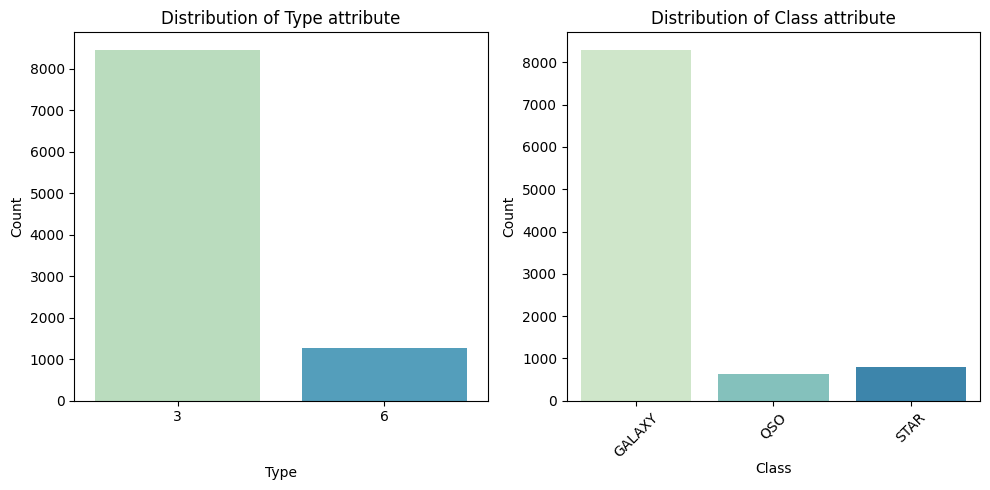

In [18]:
# Plotting 'type' attribute
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)  
sns.countplot(data=df, x='type', palette='GnBu')
plt.title("Distribution of Type attribute")
plt.xlabel("Type", labelpad= 30)
plt.ylabel("Count")

# Plotting 'class' attribute
plt.subplot(1, 2, 2)  
sns.countplot(data=df, x='class', palette='GnBu')
plt.title("Distribution of Class attribute")
plt.xlabel("Class", labelpad= 2.0)
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plotting
plt.tight_layout()  
plt.show()

For the `type` attribute we have that the majority of the objects are galaxy, while the remaning are stars.

For the `class` attribute, clearly Stars and Galaxy dominate the dataset and QSO have the lesser amount of data in the dataset.

`'type_u', 'type_g', 'type_r', 'type_i', 'type_z'` indicate the Object type classification per band. It could be interesting compare the classification of these attributes.

In [19]:
# Concatenate the two Series into a DataFrame
types_df = pd.concat([df['type_u'].value_counts(), df['type_g'].value_counts(), df['type_r'].value_counts(), df['type_i'].value_counts(), df['type_z'].value_counts()], axis=1)

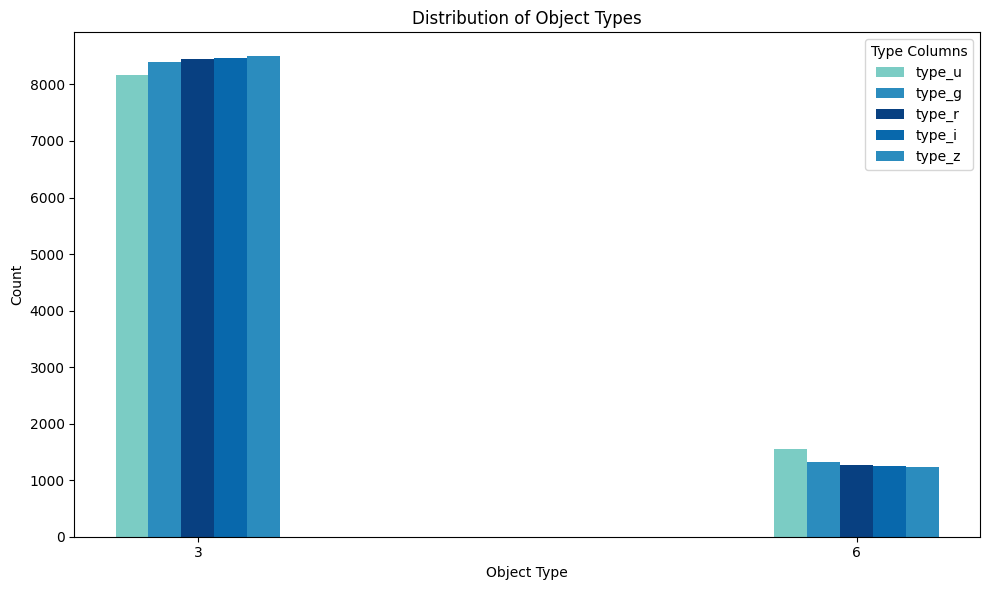

In [20]:
plt.figure(figsize=(10, 6))

# Set the positions for the bars for different 'type' columns
bar_width = 0.15  
index = types_df.index

# Plot counts for different 'type' columns side by side
colors = ['#7bccc4', '#2b8cbe', '#084081', '#0868ac', '#2b8cbe']

for i, col in enumerate(types_df.columns):
    plt.bar(index + i * bar_width, types_df[col], width=bar_width, color=colors[i], label=col)

# Plotting
plt.title("Distribution of Object Types")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.legend(title="Type Columns")
plt.xticks(index + bar_width * 2, index) 
plt.tight_layout()  
plt.show()

We can see only a little difference between the classification with different bands.

#### Red shift attribute

*Red shift is a key concept for astronomers. The term can be understood literally - The wavelength of the light is stretched, so the light is seen as 'shifted' towards the red part of the spectrum* (European SPace Agency)

Here I show the distribution of the values inside the redshift's column.

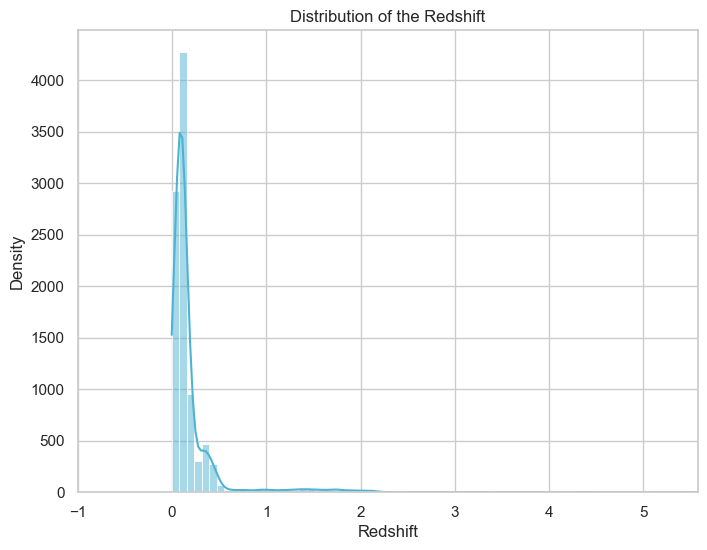

In [21]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a distribution plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(df['redshift'], bins=70, color = '#4eb3d3', kde=True)
plt.title("Distribution of the Redshift")
plt.xlim(-1, df['redshift'].max())  
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.show()

As we see in the describe report, the most of the values fall in the interval between 0 and 1.

In [22]:
df['redshift'].describe()

count    9729.000000
mean        0.186820
std         0.323613
min        -0.004021
25%         0.067693
50%         0.100188
75%         0.160170
max         5.576595
Name: redshift, dtype: float64

With the boxplot visualization we compare the distribution of the redshift variable across different categories within the column `class`. 

In [23]:
# Boxplot 
fig = px.box(df, x='class', y='redshift', title='Class vs redshift', color='class', color_discrete_sequence= ['#7bccc4', '#4eb3d3', '#08589e'])

fig.show()

Maybe the dispersion of the values in the QSO class is due to the definition of those ones : *objects beyond our Milky Way Galaxy that have a starlike visual appearance except that the optical spectrum has a large redshift*. So this objects will tend to have higher redshift (check the median interactively in the plot).

#### Model Magnitude attributes

`u, g, r, i, z` are *Shorthand alias for modelMag*, where modelMag is the model Magnitude.

Here box plots are created to visualize the distributions of various magnitude's columns at different bands against the *class* feature. 

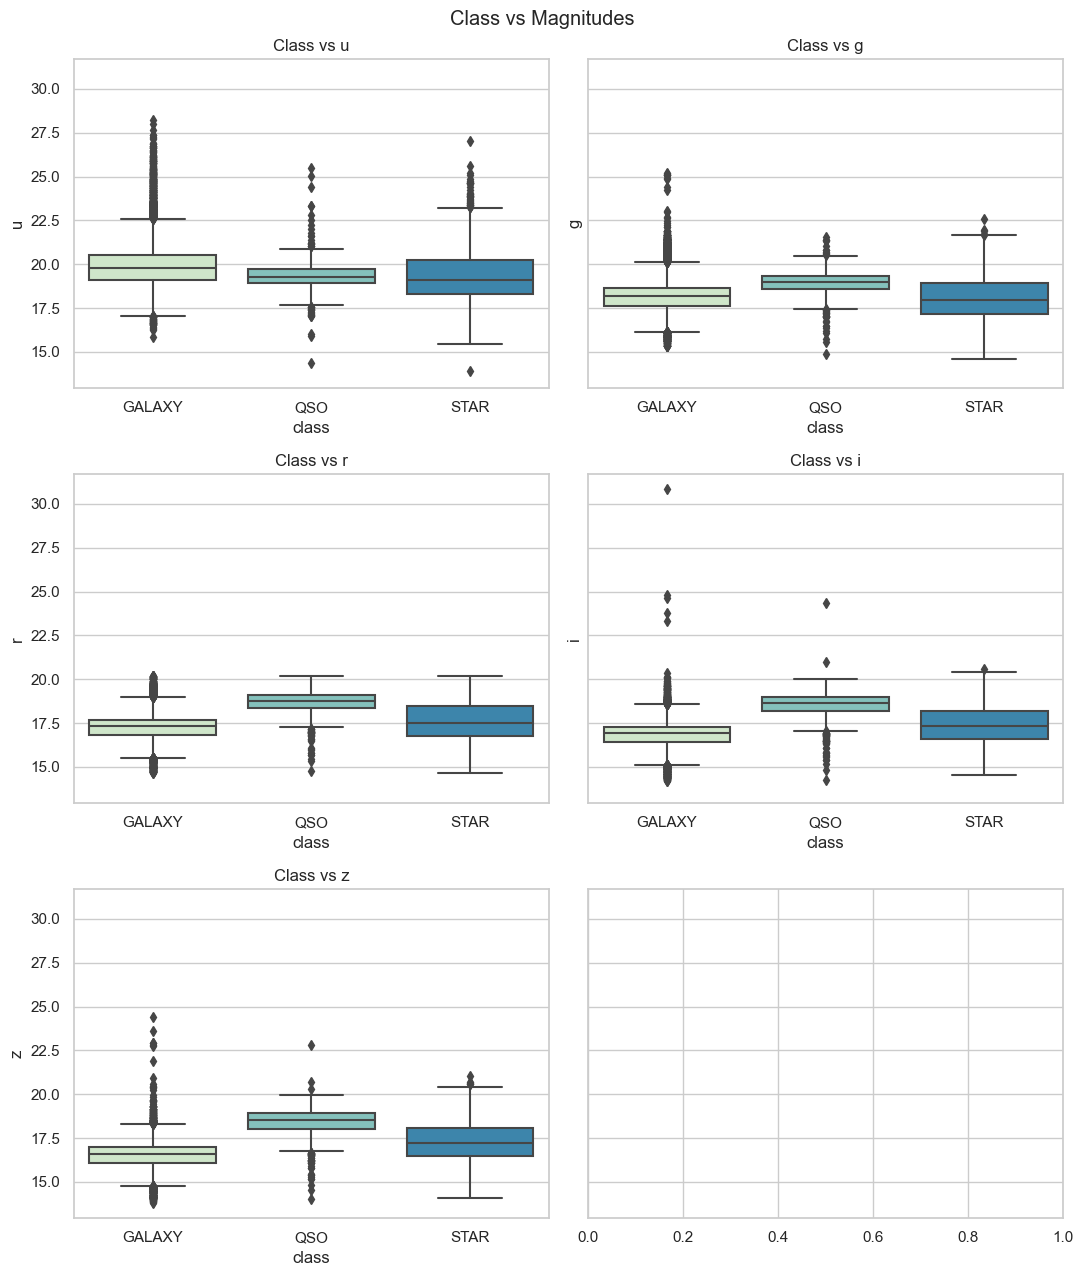

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 13), sharey=True)
cols = ["u", 'g', 'r', 'i', 'z']
fig.suptitle('Class vs Magnitudes')

for i in range(len(cols)):
    row = i // 2  # Calculate the row position
    col = i % 2   # Calculate the column position
    sns.boxplot(x="class", y=cols[i], data=df, ax=axes[row, col], palette= 'GnBu')
    axes[row, col].set_title("Class vs " + cols[i])

plt.tight_layout()
plt.show()

Observations:
- All graphs look similar
- The correlation seem similar for all classes in each bands.

#### Other attributes

*Modified Julian Date* = used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

*Plate*= Each spectroscopic exposure employs a large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number.

*FiberID* = The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding fiberID.

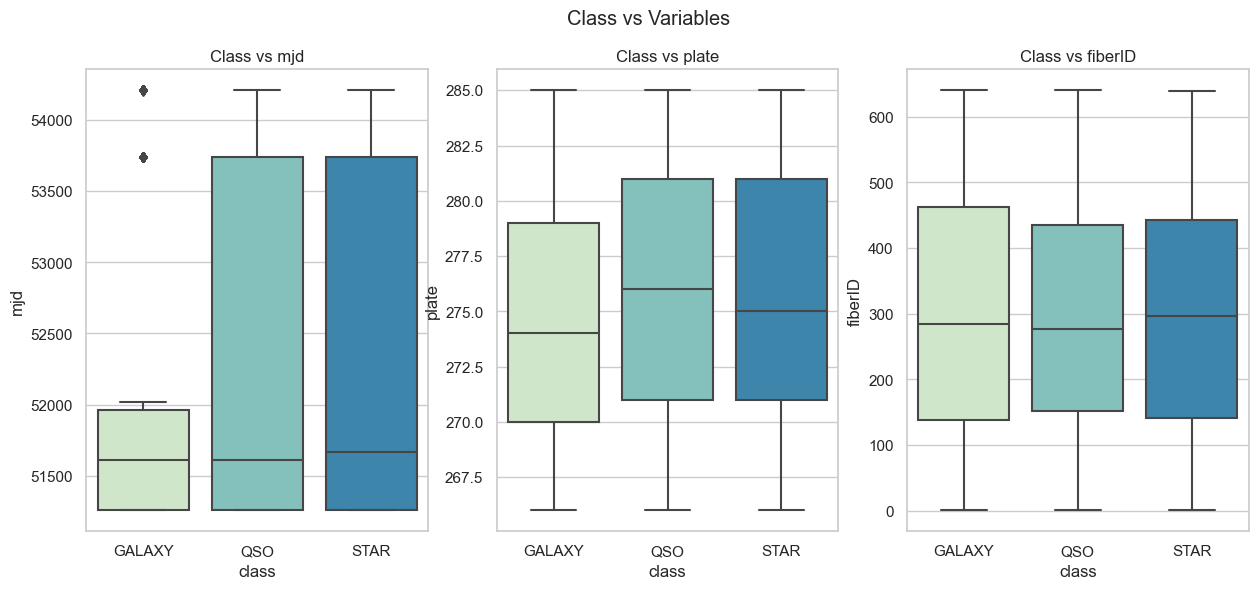

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Class vs Variables')

cols = ["mjd", "plate", "fiberID"]
new_palette = 'GnBu'  

for i in range(len(cols)):  # Corrected the variable name 'col' to 'cols'
    axes[i] = sns.boxplot(x="class", y=cols[i], data=df, ax=axes[i], palette=new_palette)
    axes[i].set_title("Class vs " + cols[i])

plt.show()

Observations:
- Modified Julian Date:
    - MJD values for STAR and QSO varies from 52000 to 56000 , whereas GALAXY band is narrower
    - This indicates that no. of galaxies discovered has decreased significantly
    
<br>

- Plate and Fiberid
    - Similar values are seen for Plate data as mjd data.
    - No significant change in fiberid is observed
    - Equal distribution.

*Right ascension (RA)* = is the celestial equivalent of longitude (Right ascension is the angular distance of an object measured eastward from the First Point of Aries)

*Magnetic declination (Dec)* = the angle between the geodetic and magnetic meridian planes

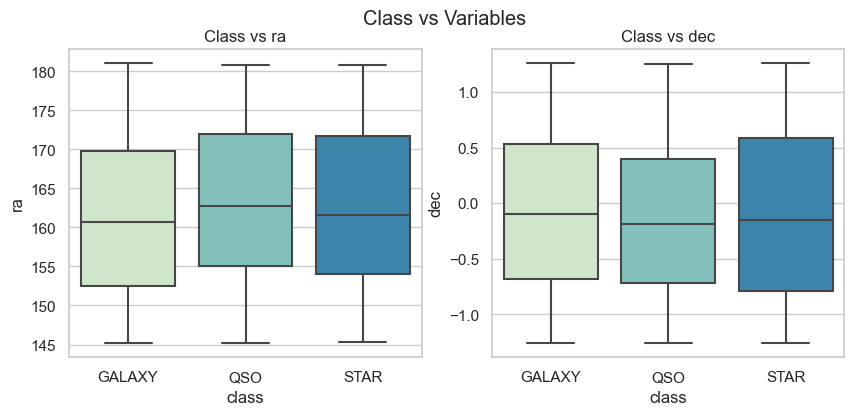

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle('Class vs Variables')

cols = ["ra", "dec"]
new_palette = 'GnBu'  

for i in range(len(cols)):  # Corrected the variable name 'col' to 'cols'
    axes[i] = sns.boxplot(x="class", y=cols[i], data=df, ax=axes[i], palette=new_palette)
    axes[i].set_title("Class vs " + cols[i])

plt.show()

- Dec position indicates stars are found from dec value 0 to 10 , galaxy from 0 to 40 , QSO from 0 to 60
- RA values for all classes are within the same range and not much difference is seen


#### Heatmap

I tried to compute the heatmap for some attributes, but first i have to encode the categorical variables.

In [27]:
# Definitions
df_encoded = df.copy()
label_encoder = LabelEncoder()

# Selecting the categorical variables 
categorical_columns = df.select_dtypes(include=['object']).columns

# Iterate through each categorical column and encode it
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

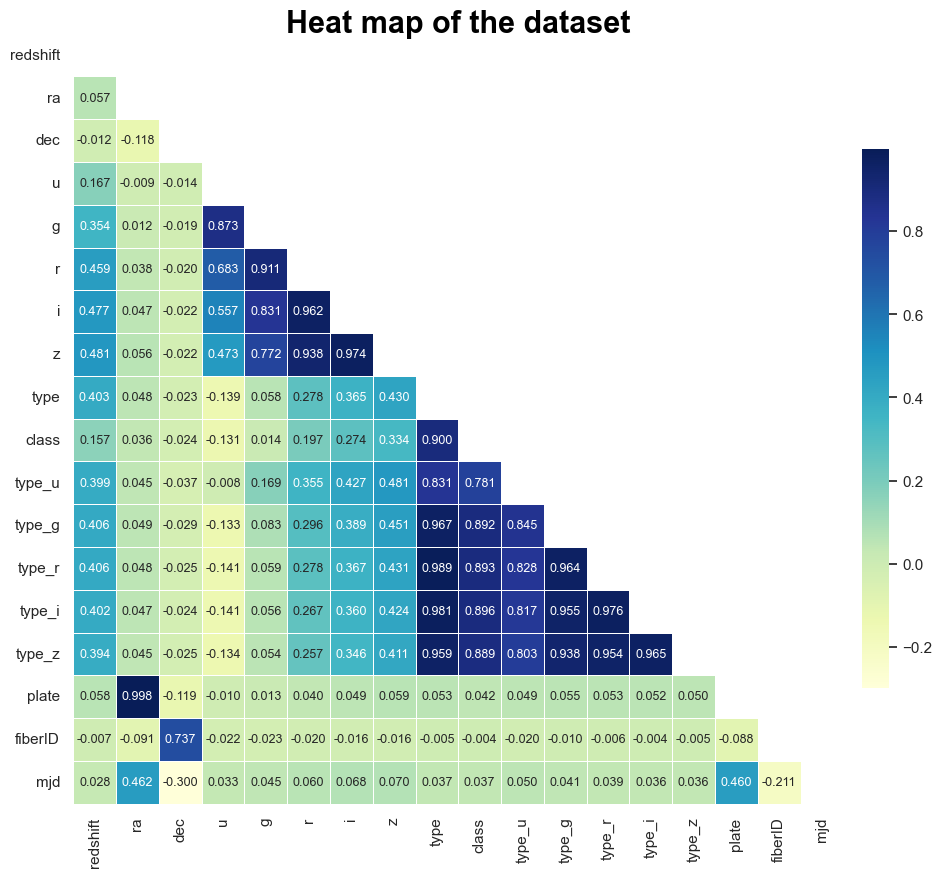

In [28]:
# Standardization
scaler = StandardScaler()
df_heatmap = df_encoded.copy()
df_heatmap[subset_columns] = scaler.fit_transform(df_heatmap[subset_columns])     # Earlier i defined the subset 

# Compute the correlation matrix
corr = df_heatmap[subset_columns].corr(numeric_only= False)

# The mask for lower left triangle 
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# The plot 
fig1, ax1 = plt.subplots( figsize=(12, 10) )
heatmap = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".3f", linewidth=.5, 
                    cbar_kws={'orientation': 'vertical', 'shrink': 0.7, 'pad': 0.02},
                    square=True, mask=mask, annot_kws={"size": 9}) 
ax1.set_title("Heat map of the dataset", fontsize= 22, fontweight= 'heavy', color = 'black', pad= 1)
plt.show()

Observations on the relevant cases:
- Redshift shows a moderate positive correlation with the type and magnitude variables.
- ra is highly correlated with plate, i imagine for physical reasons.
- u, g, r, i, z seems heavily correlated with each other, obviously because they partly explain the same concept. The same reasoning applies for the next 3 cases.
- Type, that is highly correlated with all the types variables.
- Class, that is highly correlated with all the types variables.
- type variables are highly correlated with each others.
- Fiberid and ra shows minimum correlation with class variable.


## Redshift prediction

### Regression with scikit-learn and Statsmodel

#### Scikit-learn regression

We prepared the data by separating the features and the target variable we have to predict. First we will try with the redshift.

In [29]:
# Defining the target variable we have to predict 
target = 'redshift'

# Features preparing
X = df_encoded.drop(columns = [target])
y = df_encoded[target]

Creating instances for the models. We will try with the following Machine Learning algorithms:
- (Multiple) Linear regression 
- Random forest regression
- SVM regressor

I will not perform the Lasso and Ridge regression because the number of features is too high.

In [30]:
lin_reg_red = LinearRegression()
rand_forest_red = RandomForestRegressor(n_estimators = 10, random_state = 0)
svm_red = SVR(kernel='rbf')

Then we split the data into training and test sets. In this case we splits 80% of the data to training set while 20% of the data to test set. 

This is a common practice when performing a (supervised) machine learning experiment in order to prevent overfitting 

(Source: *scikit-learn*)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fitting the model to the training data, then we make the predictions.

In [32]:
# Linear regression
lin_reg_red.fit(X_train, y_train)

y_pred_linear = lin_reg_red.predict(X_test)

In [33]:
# Random forest regression
rand_forest_red.fit(X_train, y_train)

y_pred_rand = rand_forest_red.predict(X_test)

In [34]:
# SVM regression
svm_red.fit(X_train, y_train)

y_pred_svm = svm_red.predict(X_test)

#### Evaluation

Next, the evaluation and analysis of the results.

Below some useful metrics used for understand the goodness of the model:
- **MSE**: is influenced heavily by large errors (outliers). A lower value of MSE shows better model performance. Differentiable.
- **RMSE**: large errors have a big effect on the final RMSE. Differentiable.
- **MAE**: negative errors do not decrease positive errors when summing. Not effected heavily by outliers but not always differentiable
- **R^2**: describes the proportion of variance of the dependent variable explained by the regression model.

In [35]:
# MSE
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rand = mean_squared_error(y_test, y_pred_rand)
mse_svm = mean_squared_error(y_test, y_pred_svm)

# MAE
mae_linear = mean_absolute_error(y_test,y_pred_linear)
mae_rand = mean_absolute_error(y_test,y_pred_rand)
mae_svm= mean_absolute_error(y_test,y_pred_svm)

# RMSE
rmse_linear = np.sqrt(mse_linear)
rmse_rand = np.sqrt(mse_rand)
rmse_svm = np.sqrt(mse_svm)

# R squared score
r2_linear = r2_score(y_test,y_pred_linear) * 100
r2_rand = r2_score(y_test,y_pred_rand) * 100
r2_svm= r2_score(y_test,y_pred_svm) * 100


# Create a DataFrame from the dictionary
evaluations_dict = {
    'MSE': [mse_linear, mse_rand, mse_svm],
    'MAE': [mae_linear, mae_rand, mae_svm],
    'RMSE': [rmse_linear, rmse_rand, rmse_svm],
    'R-squared': [r2_linear, r2_rand, r2_svm]
}

# Create a list of regression model names
models = ['Linear Regression', 'Random Forest Regression', 'SVM Regression']  

# Create a DataFrame with model names as the index
evaluations_df = pd.DataFrame(evaluations_dict, index=models)

# SOUNDS GOOD

In [36]:
evaluations_df

,MSE,MAE,RMSE,R-squared
Linear Regression,0.031382,0.087251,0.177149,64.459678
Random Forest Regression,0.000132,0.000784,0.011511,99.849951
SVM Regression,0.089744,0.131663,0.299573,-1.636548


The results are really poor:
- the Linear Regression has a medim-low R-squared and kinda high errors values 
- the Random Forest Regression has an incredible high R-squared and very low errors, meaning that the models is suffering from overfitting. Indeed is not plausible that the model is perfect while the other are performing bad, plus 696 is a too big number of features to have such a good result.
- On the orher side, SVM Regressor's results are tragical. 

#### Plots

From scatter plots of Actual vs Predicted you can tell how well the model is performing by comparing the subest of the original dataset (`y_test`) with the predicted values (`y_pred`). For the ideal model, the points should be closer to a diagonal line.

In [37]:
# Create a scatter plot for Actual vs Predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_linear, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_linear)], y=[min(y_test), max(y_pred_linear)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted Multiple Linear Regression')

# Show the plot
fig.show()

In [38]:
# Create a scatter plot for Actual vs Predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_rand, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_rand)], y=[min(y_test), max(y_pred_rand)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted Random Forest Regression')

# Show the plot
fig.show()

In [39]:
# Create a scatter plot for Actual vs Predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_svm, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_svm)], y=[min(y_test), max(y_pred_svm)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted Support Vector Regressor')

# Show the plot
fig.show()

The plot are showing how bad the model are performing with the predictions. In the case of Random Forest, the perfection of the plot points out the overfitting of the model.

#### Statsmodel 

Now we compute the predictions with another package, statsmodel.

In [115]:
# Recall the target
target = 'redshift'

# Define target variable and predictor variables
y_ols_red = df_encoded[target]
X_ols_red = df_encoded.drop(columns=[target])

# Split the data into training and testing sets
X_train_ols_r, X_test_ols_r, y_train_ols_r, y_test_ols_r = train_test_split(X_ols_red, y_ols_red, test_size=0.2, random_state=42)

# Fit a linear regression model
model_ols_r = sm.OLS(y_train_ols_r, sm.add_constant(X_train_ols_r)).fit()

# View the model summary (only the first table becasue the output is too long in the final non truncated version )
print(model_ols_r.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:               redshift   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     45.63
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          2.68e-154
Time:                        16:19:14   Log-Likelihood:                -2020.5
No. Observations:                7783   AIC:                             4079.
Df Residuals:                    7764   BIC:                             4211.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         


As we expected the results with this tool are also very low and not satisfactory. Statsmodel reveals a worse trend in the linear regression than sckit learn did. This could mean either that sckit-learn works better or its results are biased and not completly trustuble.

#### Normality check

Residuals in a statistical or machine learning model are the differences between observed and predicted values of data.
One of the assumption in Linear regression is that the residual should be normally distributed.

I will plot both the residual that came out from the linear regression with scikit learn and with statsmodel.

In [41]:
# Calculate the residuals (difference between actual and predicted values)
residuals_sl = y_test - y_pred_linear

# Create a histogram of residuals
fig = px.histogram(residuals_sl, title='Histogram of Residuals', labels={'value': 'Residual'}, opacity=0.90)
fig.update_traces(marker_color='#33ADA4') # Change 'purple' to the color you want

# Plotting
fig.update_layout(
    xaxis_title='Residual',
    yaxis_title='Frequency',
    showlegend=False,
    bargap=0.05,
    bargroupgap=0.1
)
fig.show()

In [42]:
# Calculate the residuals (difference between actual and predicted values)
residuals_sts = model_ols_r.resid

# Create a histogram of residuals
fig = px.histogram(residuals_sts, title='Histogram of Residuals', labels={'value': 'Residual'}, opacity=0.90)
fig.update_traces(marker_color='#33ADA4') # Change 'purple' to the color you want

# Update layout for better appearance (optional)
fig.update_layout(
    xaxis_title='Residual',
    yaxis_title='Frequency',
    showlegend=False,
    bargap=0.05,
    bargroupgap=0.1
)

# Show the plot
fig.show()

Our model’s residual seems pretty normally distributed with the residual computed from sckit-learn regression. On the other hand the plot from statsmodel has a more uncertain trend and it is has skewed distribution. However both of them present some problems, and we have a confirm of that from the the normal Q-Q plot below.

This plot is used to determine the normal distribution of errors and for normally distributed data, observations should lie approximately on a straight line.

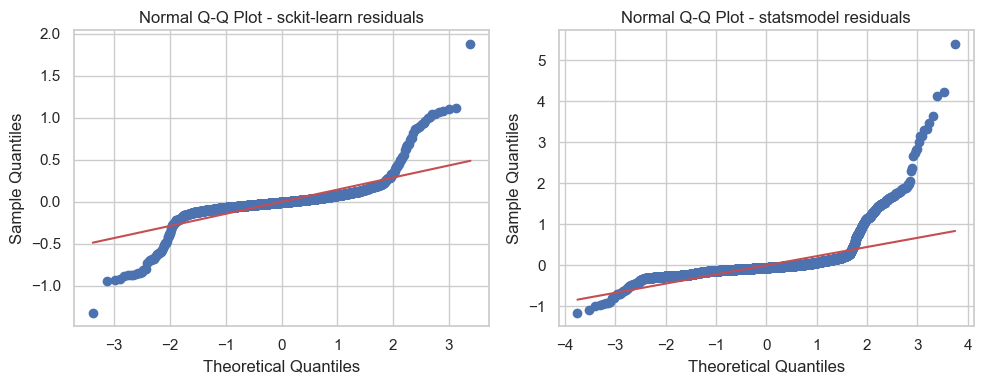

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot for residuals for sckit-learn
stats.probplot(residuals_sl, dist="norm", plot=axs[0])
axs[0].set_title('Normal Q-Q Plot - sckit-learn residuals')
axs[0].set_xlabel('Theoretical Quantiles')
axs[0].set_ylabel('Sample Quantiles')

# Plot for residuals for statsmodel
stats.probplot(residuals_sts, dist="norm", plot=axs[1])
axs[1].set_title('Normal Q-Q Plot - statsmodel residuals')
axs[1].set_xlabel('Theoretical Quantiles')
axs[1].set_ylabel('Sample Quantiles')

plt.tight_layout()  
plt.show()

#### Summary

**Curse of dimensionality**

We could state that our dataset have too many features and so the volume of the space increases exponentially. This lead to data sparsity, overfitting, visualization challenges and performance degradation, as we seen while performing the regressions.
<br><br>

**Do assumptions hold?**

Remember the Assumptions of Linear Regression:
1. Linear relationship
2. Multivariate normality
3. No or little multicollinearity
4. No auto-correlation
5. Homoscedasticity

The plot of the linear regression indicates a that there isn't a linear relationship between the prediction and the features vector, so our data might have non linear relationships betweenn the variables (when we'll perform dimensionality reduction, we'll see how the linear regression works). 

The heatmap we plotted before (on a subset of the dataset) has shown that there are highly corrrelated variables (multicollinearity), and this could lead to problems while interpreting the results.

The Multivariate normality is checked with the Q-Q plot and the plotting of the residuals. We have problems here too.

We aren't going to check the other assumptions (no auto-correlation and homoscedasticity) because we would have to go too deep down with the statiscal test, however we could conclude that the considering the dataset as it is, so with all the featues, it is problem for the regression. Also for the SVM and Random forest, which are more tolerant models respect to the linear regggression, are showing several issues in the prediction of the target.

### Regression and PCA

The previous plots and statements about the results i have obtained lead to the needing of the dimensionality reduction. I chose the PCA because is the most popular and effective technique for achieving the reduction goal.

We are starting from almost 700 attributes and with the PCA we will obtain a new set of variables, known as principal components (linear combinations of the original variables). The components I will keep should attempt to explain the maximum amount of variance in the data.

The dimensionality reduction can be also carry out manually, by selecting characteristics we want to keep (as I did previously with `subset_df`), however I preferred to implement an automatic way below.

**Note**

Several articles in the literature and sites suggest eliminating highly correlated variables before performing pca. However, working on such a large dataset, I find it difficult and laborious to find all highly correlated variables (we saw in the subset some of them, but precisely it was only a sample). For this reason I will give this assumption for granted.

#### Splitting and scaling

I am defining again the target and the features vector to have more clear code. Same for the splitting.

In [44]:
# Defining the target variable we have to predict 
target = 'redshift'

# Features preparing
X = df_encoded.drop(columns = [target])
y = df_encoded[target]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extract the features (independent variables) and standardize them.

In [46]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

Since we do not want to use all the principal components, the question now is how many principal components we should use for regression analysis.
I want to understand the optimal number of principal components for keeping the relevant information and not lose important one. I could not put any value in `n_components`, but i want decrease the computational cost, so i will put 150 (which is likewise a high number of componets).

In [47]:
# Generate all the principal compoents 
pca = PCA(n_components = 150)

In [48]:
# Fit the pca on the training and testing data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#### How many components?

First i will use the scree plot method in which a drop occurs ('elbow') to point out the optimal number of components. The components appearing after the elbow can be discarded, while the components with relatively high explained variances are kept.

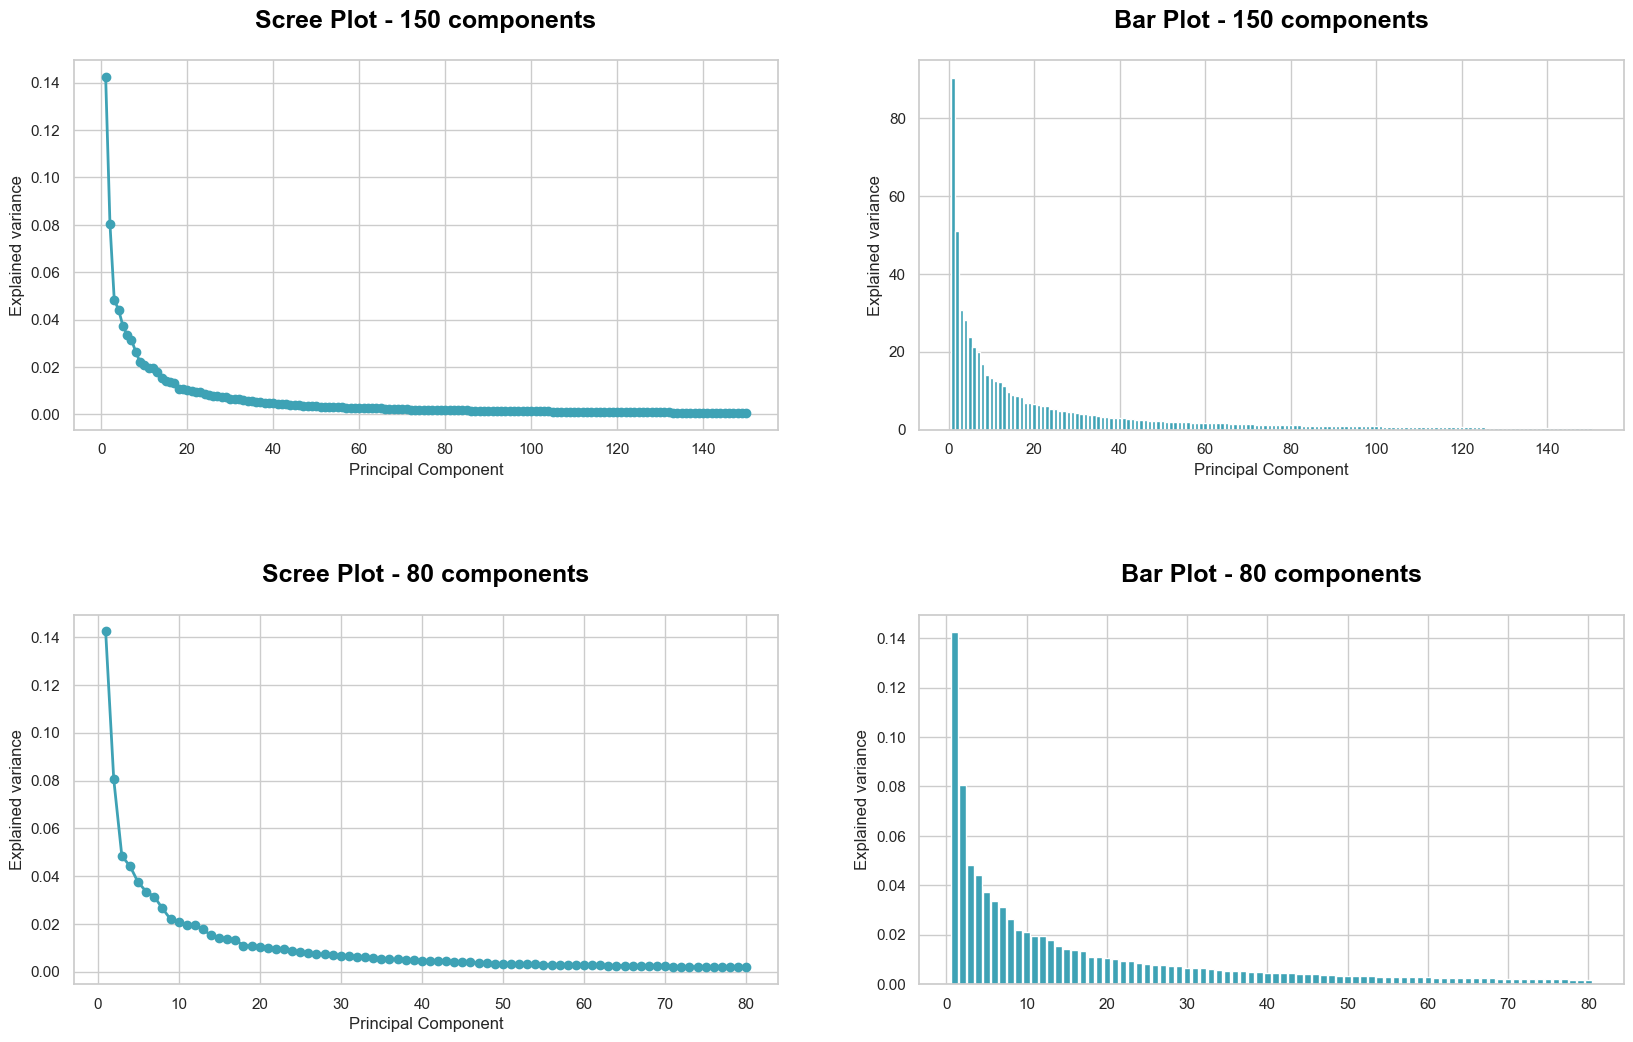

In [49]:
# Create a figure with two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'hspace': 0.5})

# Plot the first subplot
PC_values = np.arange(pca.n_components_) + 1
ax1.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='#3ea2b5')
ax1.set_title('Scree Plot - 150 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained variance')
ax1.grid(True)

# Plot the second subplot
ax2.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, color='#3ea2b5')
ax2.set_title('Bar Plot - 150 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained variance')
ax2.grid(True)

# Plot the third subplot
PC_values = np.arange(80) + 1
explained_variance_ratio = pca.explained_variance_ratio_[:80]
ax3.plot(PC_values, explained_variance_ratio, 'o-', linewidth=2, color='#3ea2b5')
ax3.set_title('Scree Plot - 80 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained variance')
ax3.grid(True)

# Plot the fourth subplot
ax4.bar(range(1, 81), explained_variance_ratio, color='#3ea2b5')
ax4.set_title('Bar Plot - 80 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax2.set_xlabel('Principal Component')
ax4.set_ylabel('Explained variance')
ax4.grid(True)

# Show the combined plot
plt.show()

Thanks to these 2 plots we can see that the elbow and the relevant explained variance is among 0 and 60 components. 

This code below aids in understanding how different numbers of principal components affect the RMSE of the linear regression model, helping to determine the optimal number of components for a more accurate regression model.
I will run this code only with the Linear Regression, because if I did this for every model, the computation time would be very big.

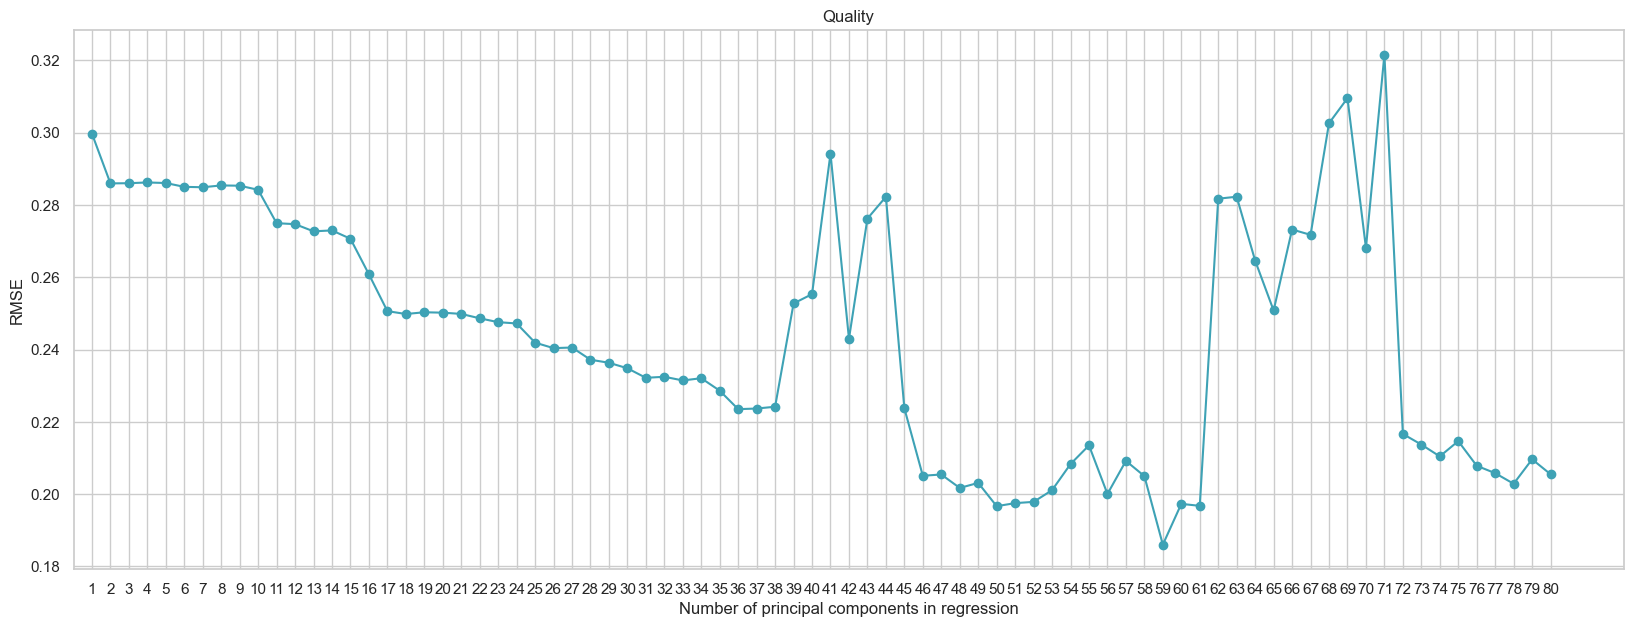

In [50]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize linear regression instance
lin_reg = LinearRegression()

# To store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, 81):
    # Cross_val_score splits the data into multiple subsets (cv) and calculates the RMSE for each fold. 
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pca[:,:i], 
                                      y_train, 
                                      cv=cv, 
                                      # negative RMSE that has to multiplied by -1 to obtain the actual RMSE value 
                                      # mean of the RMSE values across all folds, giving a single RMSE value for the current principal component.
                                      scoring='neg_root_mean_squared_error').mean()    
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.figure(figsize=(20, 7))
plt.plot(rmse_list, '-o', color='#3ea2b5')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1)
plt.xticks(np.arange(80), np.arange(1, 81))
plt.show()

We see that the training set performance of PCR initially decreases, then it has a unstable trend.

In [51]:
# Computing the cumulative explained variance  
sum = 0
for i in range(59):
    temp = round(pca.explained_variance_ratio_[i]*100, 2)
    sum += temp
print('Variance:', round(sum), '%')

Variance: 84 %


This code computes and prints the cumulative percentage of variance explained by the first x principal components, giving you an idea of how much of the total variance in the data is captured by these components.

#### Fitting and predicting

Choosing the lowest value of principal components in the RMSE plot. If if we had looked only to the explained variance values, a lower number of components it would have worked anyway. However, i tried to find a trade off number, in order to have better results in terms of metrics.

Indeed, with 5,10,20 components, the results of the regressions (with this target) were quite bad. For this reason i found that 59 is a good number principal components.

In [52]:
# Optimal number of principal components
best_pc_num = 59

In [53]:
# Checking the shape
X_train_pca[:, :best_pc_num].shape

(7783, 59)

#### Hyperparameter tuning

A grid search is performed using GridSearchCV to find the best hyperparameters (alphas) for 
- the Lasso and Ridge regression model
- Random Forest Regressor
- SVR regressor

In [54]:
## --------------------------------LASSO AND RIDGE --------------------------------##
# Define a range of alpha values to search
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0]  # Adjust the range as needed

# Define the parameter grid for Ridge and Lasso
param_grid = [{'alpha': alpha_values, 'max_iter': [10000]}]

# Perform grid search for Ridge
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid_search.fit(X_train_pca[:, :best_pc_num], y_train)

# Perform grid search for Lasso
lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='r2')
lasso_grid_search.fit(X_train_pca[:, :best_pc_num], y_train)

# Get the best parameters for Ridge and Lasso
best_alpha_ridge = ridge_grid_search.best_params_['alpha']
best_alpha_lasso = lasso_grid_search.best_params_['alpha']

print("Best Ridge alpha:", best_alpha_ridge)
print("Best Lasso alpha:", best_alpha_lasso)

Best Ridge alpha: 10.0
Best Lasso alpha: 0.001


For the Random Forest and the Support Vector Machine Regressor I pre-computed several values of the paramaters (max_depth, max_leaf_nodes, C, epsilon and so on), but then I commented everthing and removed some values because the computation time was too long (almost half an hour).

In [55]:
'''
## -------------------------------- RANDOM FOREST REGRESSOR --------------------------------##
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Grid
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, verbose=3) 

# Fit grid search
grid_search.fit(X_train_pca[:,:best_pc_num], y_train)

# Print grid search summary
print("Best Estimators for SVR:", grid_search.best_estimator_)
'''

'\n## -------------------------------- RANDOM FOREST REGRESSOR --------------------------------##\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = [\'sqrt\']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n\n# Create the param grid\nparam_grid = {\'n_estimators\': n_estimators,\n               \'max_features\': max_features,\n               \'max_depth\': max_depth,\n               \'min_samples_split\': min_samples_split,\n               \'min_samples_leaf\': min_samples_leaf}\n# Grid\ngrid_search = GridSearchCV(RandomForestRegressor(), param_grid, verbose=3) \n\n# Fit grid search\ngrid_search.fit(X_train_pca[:

In [56]:
'''
## -------------------------------- SVM REGRESSOR --------------------------------##
# Define grid search
param_grid = {'C': [0.01, 0.1, 1.0], 
              'gamma':[0.001,0.01,0.1], 
              'epsilon': [0.1, 0.2, 0.5]}  

# Grid
grid_search = GridSearchCV(SVR(), param_grid, verbose=3) 

# Fit grid search
grid_search.fit(X_train_pca[:,:best_pc_num], y_train)

# Print grid search summary
print("Best Estimators for SVR:", grid_search.best_estimator_)
'''

'\n## -------------------------------- SVM REGRESSOR --------------------------------##\n# Define grid search\nparam_grid = {\'C\': [0.01, 0.1, 1.0], \n              \'gamma\':[0.001,0.01,0.1], \n              \'epsilon\': [0.1, 0.2, 0.5]}  \n\n# Grid\ngrid_search = GridSearchCV(SVR(), param_grid, verbose=3) \n\n# Fit grid search\ngrid_search.fit(X_train_pca[:,:best_pc_num], y_train)\n\n# Print grid search summary\nprint("Best Estimators for SVR:", grid_search.best_estimator_)\n'

#### Fitting and predicting

We can proceed to run PCR (principal component regression) and other models. First we fit the models and we make the predictions.

In [57]:
# Linear Regression
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca[:,:best_pc_num], y_train)

# Ridge and Lasso 
ridge_reg_pca = Ridge(alpha=10.0, max_iter=10000)  
lasso_reg_pca = Lasso(alpha=0.001, max_iter=10000) 
ridge_reg_pca.fit(X_train_pca[:,:best_pc_num],y_train)
lasso_reg_pca.fit(X_train_pca[:,:best_pc_num],y_train)

# Elastic Net Regression
enet_reg_pca = ElasticNet()
enet_reg_pca.fit(X_train_pca[:,:best_pc_num],y_train)

# Random Forest Regressor
rand_reg_pca = RandomForestRegressor()
rand_reg_pca.fit(X_train_pca[:,:best_pc_num], y_train)

# SVM Regressor
svm_reg_pca = SVR(kernel= 'rbf', gamma = 0.001)
svm_reg_pca.fit(X_train_pca[:,:best_pc_num], y_train)

# Predict on the test set
y_pred_lin_pca = lin_reg_pca.predict(X_test_pca[:,:best_pc_num])
y_pred_ridge_pca = ridge_reg_pca.predict(X_test_pca[:,:best_pc_num])
y_pred_lasso_pca= lasso_reg_pca.predict(X_test_pca[:,:best_pc_num])
y_pred_enet_pca= enet_reg_pca.predict(X_test_pca[:,:best_pc_num])
y_pred_rand_pca = rand_reg_pca.predict(X_test_pca[:,:best_pc_num])
y_pred_svm_pca = svm_reg_pca.predict(X_test_pca[:,:best_pc_num])

#### Evaluation with metrics

In [58]:
# MSE
mse_linear = mean_squared_error(y_test, y_pred_lin_pca)
mse_ridge = mean_squared_error(y_test, y_pred_ridge_pca)
mse_lasso = mean_squared_error(y_test, y_pred_lasso_pca)
mse_enet = mean_squared_error(y_test, y_pred_enet_pca)
mse_rand = mean_squared_error(y_test, y_pred_rand_pca)
mse_svm = mean_squared_error(y_test, y_pred_svm_pca)

# MAE
mae_linear = mean_absolute_error(y_test,y_pred_lin_pca)
mae_ridge = mean_absolute_error(y_test,y_pred_ridge_pca)
mae_lasso = mean_absolute_error(y_test,y_pred_lasso_pca)
mae_enet = mean_absolute_error(y_test,y_pred_enet_pca)
mae_rand = mean_absolute_error(y_test,y_pred_rand_pca)
mae_svm= mean_absolute_error(y_test,y_pred_svm_pca)

# RMSE
rmse_linear = np.sqrt(mse_linear)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)
rmse_enet = np.sqrt(mse_enet)
rmse_rand = np.sqrt(mse_rand)
rmse_svm = np.sqrt(mse_svm)


# R squared score
r2_linear = r2_score(y_test,y_pred_lin_pca) * 100
r2_ridge = r2_score(y_test,y_pred_ridge_pca) * 100
r2_lasso = r2_score(y_test,y_pred_lasso_pca) * 100
r2_enet = r2_score(y_test,y_pred_enet_pca) * 100
r2_rand = r2_score(y_test,y_pred_rand_pca) * 100
r2_svm= r2_score(y_test,y_pred_svm_pca) * 100


# Create a DataFrame from the dictionary
evaluations_dict = {
    'MSE': [ mse_linear, mse_ridge, mse_lasso, mse_enet, mse_rand, mse_svm],
    'MAE': [ mae_linear, mae_ridge, mae_lasso, mae_enet, mae_rand, mae_svm],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lasso, rmse_enet ,rmse_rand, rmse_svm],
    'R-squared': [r2_linear,r2_ridge, r2_lasso, r2_enet ,r2_rand, r2_svm]
}

# Create a list of regression model names
models = ['Linear Regression', 'Ridge Regression ', 'Lasso Regression', 'Elastic Net Regression', 'Random Forest Regression', 'SVM Regression']

# Create a DataFrame with model names as the index
evaluations_df = pd.DataFrame(evaluations_dict, index=models)
evaluations_df = evaluations_df.round(3)

In [59]:
evaluations_df

,MSE,MAE,RMSE,R-squared
Linear Regression,0.021,0.080,0.145,76.214
Ridge Regression,0.021,0.080,0.145,76.217
Lasso Regression,0.021,0.079,0.144,76.381
Elastic Net Regression,0.070,0.127,0.265,20.251
Random Forest Regression,0.012,0.046,0.107,86.963
SVM Regression,0.010,0.055,0.102,88.303


The values that came out of the regression model are suggesting the PCR perfomed better on the reduced dataset than the entire one. So dimensionality reduction was fundamental for the regression task and with this dataset.

We can select both the Random Forest Regressor and SVM Regressor as the best models, why?


**Random Forest:**
- Random Forest models can handle a large number of features efficiently.
- They excel in capturing non-linear relationships between features and the target variable.
- Random Forests can handle high-dimensional data well and are generally less affected by multicollinearity among features.

**Support Vector Machine (SVM) Regressor**
- SVMs can handle non-linear data by using the kernel trick.
- SVMs are effective with high-dimensional data as they work well in high-dimensional spaces.

These could be some reasons that explain the better performance.

Here i want to confirm the improvment with the Hyperparameter Tuning. I will show only the Lasso for convenience and because was one of the best example, but the improvment was seen also with the other models.

In [60]:
# Before Hyperparameter Tuning
model_ex = Lasso()
model_ex.fit(X_train_pca[:,:best_pc_num], y_train)
y_pred_ex = model_ex.predict(X_test_pca[:,:best_pc_num])

print("MSE", mean_squared_error(y_test, y_pred_ex).round(3))
print("MAE", mean_absolute_error(y_test,y_pred_ex).round(3))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred_ex)).round(3))
print("R-squared", round(r2_score(y_test,y_pred_ex) * 100, 3))

# After Hyperparameter Tuning 
evaluations_df.loc['Lasso Regression',:]

MSE 0.082
MAE 0.144
RMSE 0.286
R-squared 7.595


MSE           0.021
MAE           0.079
RMSE          0.144
R-squared    76.381
Name: Lasso Regression, dtype: float64

#### Plots

In this plots we compare the actual values against the predicted ones. 
I will avoid the plotting of the Elastic Net because it performed really bad.

In [61]:
# Create a scatter plot for Actual vs Predicted with PCR
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_lin_pca, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_lin_pca)], y=[min(y_test), max(y_pred_lin_pca)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted PCR')

# Show the plot
fig.show()

We see that the model has a better performance with respect to the Linear Regression without the PCA, but there are still lot of values that are not well explained by the model.

In [62]:
# Create subplots 
fig = make_subplots(rows=1, cols=2, subplot_titles=('Ridge Regression Model', 'Lasso Regression Model'))

# Scatter plot for Model 1
fig.add_trace(go.Scatter(x=y_test, y=y_pred_ridge_pca, mode='markers', name='Ridge Regression Model',
                         marker=dict(color='#33ADA4')), row=1, col=1)

# Scatter plot for Model 2
fig.add_trace(go.Scatter(x=y_test, y=y_pred_lasso_pca, mode='markers', name='Lasso Regression Model',
                         marker=dict(color='#2b8cbe')), row=1, col=2)

# Perfect Prediction Line for both subplots
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_ridge_pca)], y=[min(y_test), max(y_pred_ridge_pca)],
                         mode='lines', line=dict(color='red', dash='dash'), name='Perfect Prediction Line'),
                         row=1, col=1)

fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_lasso_pca)], y=[min(y_test), max(y_pred_lasso_pca)],
                         mode='lines', line=dict(color='red', dash='dash'), name='Perfect Prediction Line'),
                         row=1, col=2)

# Set axes labels and title
fig.update_xaxes(title_text='Actual Values', row=1, col=1)
fig.update_xaxes(title_text='Actual Values', row=1, col=2)
fig.update_yaxes(title_text='Predicted Values', row=1, col=1)
fig.update_yaxes(title_text='Predicted Values', row=1, col=2)
fig.update_layout(title='Ridge and Lasso Actual vs Predicted', showlegend=False)

# Show the plot
fig.show()

Same for Ridge Regression and Lasso Regression.

In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_rand_pca, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_rand_pca)], y=[min(y_test), max(y_pred_rand_pca)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted with Random Forest and PCA')

# Show the plot
fig.show()

The Random Forest plot shows a better tendency, maybe for all the reasons i stated before. However we don't have a super high value of accuracy (recall the R^2 scores we computed before), so the plot can't be perfect.

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_svm_pca, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test), max(y_pred_svm_pca)], y=[min(y_test), max(y_pred_svm_pca)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted with SVM and PCA')

# Show the plot
fig.show()

Same of the Random Forest. In both plots we can see that the points aggregate in the interval that goes from 0 to 0.5, as we have seen in the statistics in the beginning of the project. 

### Regression with PCA and statsmodels

In [65]:
# Standardize the features
scaler = StandardScaler()
X_ols_standardized = scaler.fit_transform(X_ols_red)

# Applying PCA to reduce dimensionality
pca = PCA(n_components=59)  # Specify the number of principal components
X_pca = pca.fit_transform(X_ols_standardized)

# Split the data into training and testing sets for PCA-transformed data
X_train_pca, X_test_pca, y_train_ols, y_test_ols = train_test_split(X_pca, y_ols_red, test_size=0.2, random_state=42)

# Fit a linear regression model using the PCA-transformed predictors
model_pca = sm.OLS(y_train_ols, sm.add_constant(X_train_pca)).fit()

# View the model summary for PCA-transformed data
print(model_pca.summary())

                            OLS Regression Results                            
Dep. Variable:               redshift   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     393.4
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:51:04   Log-Likelihood:                 2988.5
No. Observations:                7783   AIC:                            -5857.
Df Residuals:                    7723   BIC:                            -5439.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1868      0.002     99.479      0.0

With the application of the dimensionality reduction the improvements with statsmodel are considerable:
- higher R-squared: the variance in the dependent variable is explained by the independent variables in the model
- F-statistic: model is statistically significant.
- Log-Likelihood, AIC, and BIC: the model fits the data quite well.

### Regression and K-Folds Cross-Validation

Here I attempt to fit the Regression models we have sees with the validation strategy "5-fold cross-validation", in order to check which models are performing better for this task. Also we will assest whether or not the results are better than before (when we use only the classic splittig with train and test sets). 

Moreover the cross validation is a useful technique to mitigate the effect of overfitting (and we have stated the my models are suffering of it).

In [66]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0, max_iter=10000),
    "Lasso Regression": Lasso(alpha=0.01, max_iter=10000),
    "Random Forest Regression": RandomForestRegressor(),
    "SVM Regression": SVR(kernel= 'rbf', gamma = 0.001),
}

# Initialize empty dictionaries to store evaluation metrics
evaluation_metrics = {
    'Model': [],
    'MSE': [],
    'MAE': [],
    'RMSE': [],
    'R-squared': [],
}

# Define the list of scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

# Perform cross-validation and calculate metrics for each model
for model_name, model in models.items():
    # Computing the metrics
    cv_results = cross_validate(model, X_train_pca[:, :best_pc_num], y_train, cv=5, scoring=scoring_metrics)

    # Append metrics to the dictionary with the appropriate transformations
    evaluation_metrics['Model'].append(model_name)
    evaluation_metrics['MSE'].append(-cv_results['test_neg_mean_squared_error'].mean())
    evaluation_metrics['MAE'].append(-cv_results['test_neg_mean_absolute_error'].mean())
    evaluation_metrics['RMSE'].append(-cv_results['test_neg_root_mean_squared_error'].mean())
    evaluation_metrics['R-squared'].append(cv_results['test_r2'].mean() * 100)

# Create a DataFrame from the dictionary
cross_validation_results = pd.DataFrame(evaluation_metrics)
cross_validation_results.set_index('Model', inplace=True)
cross_validation_results = cross_validation_results.round(3)

In [67]:
# Results of cross validation
cross_validation_results

,MSE,MAE,RMSE,R-squared
Model,,,,
Linear Regression,0.041,0.079,0.199,62.973
Ridge Regression,0.041,0.079,0.198,63.209
Lasso Regression,0.031,0.076,0.174,71.949
Random Forest Regression,0.028,0.055,0.165,74.829
SVM Regression,0.023,0.059,0.150,79.153


In [68]:
# Previous results 
evaluations_df

,MSE,MAE,RMSE,R-squared
Linear Regression,0.021,0.080,0.145,76.214
Ridge Regression,0.021,0.080,0.145,76.217
Lasso Regression,0.021,0.079,0.144,76.381
Elastic Net Regression,0.070,0.127,0.265,20.251
Random Forest Regression,0.012,0.046,0.107,86.963
SVM Regression,0.010,0.055,0.102,88.303


***Why the results are worst?***

The differences in model performance metrics between the simple train-test splitting and k-folds cross-validation strategies could be attributed to several reasons:
- K-fold cross-validation, uses multiple splits (folds) of the data, providing a more robust estimation of model performance, reducing the impact of randomness in a single split (while the train-test splitting is influenced by randomness).
- K-fold cross-validation often provides a more realistic estimate of the model's ability to generalize to unseen data, while train-test splitting may overestimate or underestimate the model's performance.
- Cross-validation averages over multiple folds, which can help identify overfitting.

### Regression with Validation set

Here I fit the regression with another validation strategy: train-validation-test. This method prevent the model from overfitting and permits the evaluation of the model in an effective way.

I will perform the splittin with these percentages: 80/10/10%.

In [69]:
# In the first step we will split the data in training and remaining dataset
X_train2, X_rem, y_train2, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data) we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_rem,y_rem, test_size=0.5, random_state= 42)

Now the procedure is the same as before, so i will re-write all the code of the section "Regression + PCA". 
- First i will train the models with the training set.
- Then i will make predictions with the validation set.
- Once we have used the validation set to determine the algorithm and parameter choices that we would like to use in production, the test set is used for the final evaluation.

In [70]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_train_scaled2 = StandardScaler().fit_transform(X_train2)
X_valid_scaled2 = StandardScaler().fit_transform(X_valid2)
X_test_scaled2 = StandardScaler().fit_transform(X_test2)

In [71]:
# Generate all the principal compoents with the optimal number we have seen before  
pca2= PCA(n_components = 59)

In [72]:
# Fit the pca on the training, validation and testing sets
X_train_pca2 = pca2.fit_transform(X_train_scaled2)
X_valid_pca2 = pca2.transform(X_valid_scaled2)
X_test_pca2 = pca2.transform(X_test_scaled2)

Fitting and predicting on the validation set.

In [73]:
# Linear Regression
lin_reg_pca2 = LinearRegression()
lin_reg_pca2.fit(X_train_pca2, y_train2)

# Ridge and Lasso 
ridge_reg_z2 = Ridge(alpha=10.0, max_iter=10000)  
lasso_reg_z2 = Lasso(alpha=0.01, max_iter=10000) 
ridge_reg_z2.fit(X_train_pca2,y_train2)
lasso_reg_z2.fit(X_train_pca2,y_train2)

# Random Forest
rand_reg_pca2 = RandomForestRegressor()
rand_reg_pca2.fit(X_train_pca2, y_train2)

# SVM
svm_reg_pca2 = SVR(kernel= 'rbf', C=100, gamma=0.0001)
svm_reg_pca2.fit(X_train_pca2, y_train2)

# Predict on the validation set
y_valid_pred_lin_pca2 = lin_reg_pca2.predict(X_valid_pca2)
y_valid_pred_ridge_pca2 = ridge_reg_z2.predict(X_valid_pca2)
y_valid_pred_lasso_pca2 = lasso_reg_z2.predict(X_valid_pca2)
y_valid_pred_rand_pca2 = rand_reg_pca2.predict(X_valid_pca2)
y_valid_pred_svm_pca2 = svm_reg_pca2.predict(X_valid_pca2)

Now the evaluation on the validation set.

In [74]:
# MSE
mse_linear2 = mean_squared_error(y_valid2, y_valid_pred_lin_pca2)
mse_ridge2 = mean_squared_error(y_valid2, y_valid_pred_ridge_pca2)
mse_lasso2 = mean_squared_error(y_valid2, y_valid_pred_lasso_pca2)
mse_rand2 = mean_squared_error(y_valid2, y_valid_pred_rand_pca2)
mse_svm2 = mean_squared_error(y_valid2, y_valid_pred_svm_pca2)

# MAE
mae_linear2 = mean_absolute_error(y_valid2,y_valid_pred_lin_pca2)
mae_ridge2 = mean_absolute_error(y_valid2,y_valid_pred_ridge_pca2)
mae_lasso2 = mean_absolute_error(y_valid2,y_valid_pred_lasso_pca2)
mae_rand2 = mean_absolute_error(y_valid2,y_valid_pred_rand_pca2)
mae_svm2 = mean_absolute_error(y_valid2,y_valid_pred_svm_pca2)

# RMSE
rmse_linear2 = np.sqrt(mse_linear2)
rmse_ridge2 = np.sqrt(mse_ridge2)
rmse_lasso2 = np.sqrt(mse_lasso2)
rmse_rand2 = np.sqrt(mse_rand2)
rmse_svm2 = np.sqrt(mse_svm2)

# R squared score
r2_linear2 = r2_score(y_valid2,y_valid_pred_lin_pca2) * 100
r2_ridge2 = r2_score(y_valid2,y_valid_pred_ridge_pca2) * 100
r2_lasso2 = r2_score(y_valid2,y_valid_pred_lasso_pca2) * 100
r2_rand2 = r2_score(y_valid2,y_valid_pred_rand_pca2) * 100
r2_svm2 = r2_score(y_valid2,y_valid_pred_svm_pca2) * 100


# Create a DataFrame from the dictionary
evaluations_dict2 = {
    'MSE': [ mse_linear2, mse_ridge2, mse_lasso2, mse_rand2, mse_svm2],
    'MAE': [ mae_linear2, mae_ridge2, mae_lasso2 , mae_rand2, mae_svm2],
    'RMSE': [rmse_linear2, rmse_ridge2, rmse_lasso2 , rmse_rand2, rmse_svm2],
    'R-squared': [r2_linear2,r2_ridge2, r2_lasso2 , r2_rand2, r2_svm2]
}

# Create a list of regression model names
models = ['Linear Regression', 'Ridge Regression ', 'Lasso Regression', 'Random Forest Regression', 'SVM Regression']

# Create a DataFrame with model names as the index
validSet_evaluations_df = pd.DataFrame(evaluations_dict2, index=models)
validSet_evaluations_df = validSet_evaluations_df.round(3)

In [75]:
validSet_evaluations_df

,MSE,MAE,RMSE,R-squared
Linear Regression,0.023,0.075,0.151,76.540
Ridge Regression,0.023,0.075,0.151,76.540
Lasso Regression,0.024,0.076,0.156,75.101
Random Forest Regression,0.020,0.051,0.140,79.704
SVM Regression,0.013,0.059,0.113,86.767


Now we choose the best model and we perform the final prediction and evaluations on the test set. I choose the SVM Regressor.

In [76]:
# Predict on the test set
y_final_rand = svm_reg_pca2.predict(X_test_pca2)

In [77]:
# MSE
test_mse = mean_squared_error(y_test2, y_final_rand).round(3)
test_mae= mean_absolute_error(y_test2,y_final_rand).round(3)
test_rmse = np.sqrt(test_mse).round(3)
test_r2= round(r2_score(y_test2,y_final_rand) * 100,3)

print("Test Set Metrics:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"Root Mean Squared Error: {test_rmse}")
print(f"R-squared (R2): {test_r2}")

Test Set Metrics:
Mean Squared Error: 0.033
Mean Absolute Error: 0.067
Root Mean Squared Error: 0.182
R-squared (R2): 73.376


The result are pretty acceptable (sometimes improved!) considering we have done the train-validation-test strategy. Indeed, splitting the dataset into three sets is useful for avoiding overitting and ensuring model's ability to generalize, but this can lead to a decrease in model's result. 

## Magnitude prediction

Here I follow the same steps as before, but I try to predict the magnitude (the model magnitude, in particula 'z', the infrared wavelength). I will omits some explanations, descriptions and parts of the code that i have written before.

### Regression with scikit-learn and Statsmodel

#### Scikit-learn regression

In [78]:
# Defining the target variable we have to predict 
target = 'z'

# Features preparing
X_z = df_encoded.drop(columns = [target])
y_z = df_encoded[target]

# Models definitions 
lin_reg_z = LinearRegression()
rand_forest_z = RandomForestRegressor(n_estimators = 10, random_state = 0)
svm_z = SVR(kernel='rbf')

X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X_z, y_z, test_size=0.2, random_state=42)

# Linear regression
lin_reg_z.fit(X_train_z, y_train_z)
y_pred_linear_z = lin_reg_z.predict(X_test_z)

# Random forest regression
rand_forest_z.fit(X_train_z, y_train_z)
y_pred_rand_z = rand_forest_z.predict(X_test_z)

# SVM regression
svm_z.fit(X_train_z, y_train_z)
y_pred_svm_z = svm_z.predict(X_test_z)

#### Evaluation

In [79]:
# MSE
mse_linear_z = mean_squared_error(y_test_z, y_pred_linear_z)
mse_rand_z = mean_squared_error(y_test_z, y_pred_rand_z)
mse_svm_z = mean_squared_error(y_test_z, y_pred_svm_z)

# MAE
mae_linear_z = mean_absolute_error(y_test_z,y_pred_linear_z)
mae_rand_z = mean_absolute_error(y_test_z,y_pred_rand_z)
mae_svm_z= mean_absolute_error(y_test_z,y_pred_svm_z)

# RMSE
rmse_linear_z = np.sqrt(mse_linear_z)
rmse_rand_z = np.sqrt(mse_rand_z)
rmse_svm_z = np.sqrt(mse_svm_z)

# R squared score
r2_linear_z = r2_score(y_test_z,y_pred_linear_z) * 100
r2_rand_z = r2_score(y_test_z,y_pred_rand_z) * 100
r2_svm_z= r2_score(y_test_z,y_pred_svm_z) * 100

# Create a DataFrame from the dictionary
evaluations_dict_z = {
    'MSE': [mse_linear_z, mse_rand_z, mse_svm_z],
    'MAE': [mae_linear_z, mae_rand_z, mae_svm_z],
    'RMSE': [rmse_linear_z, rmse_rand_z, rmse_svm_z],
    'R-squared': [r2_linear_z, r2_rand_z, r2_svm_z]
}

# Create a list of regression model names
models = ['Linear Regression', 'Random Forest Regression', 'SVM Regression']

# Create a DataFrame with model names as the index
evaluations_df_z = pd.DataFrame(evaluations_dict_z, index=models)

In [80]:
evaluations_df_z

,MSE,MAE,RMSE,R-squared
Linear Regression,0.171025,0.274925,0.413552,81.959807
Random Forest Regression,0.000781,0.002215,0.027953,99.917577
SVM Regression,0.908773,0.697393,0.953296,4.139996


The results are various:
- the linear regression is shwoing a kinda good beahviour.
- the random forest regressor is clearly overfitting.
- and the SVM regressor has tragic results.

#### Plots

The plots reflect what we have assets with the metrics.

In [81]:
# Create a scatter plot for Actual vs Predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_linear_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_linear_z)], y=[min(y_test_z), max(y_pred_linear_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted Multiple Linear Regression')

# Show the plot
fig.show()

In [82]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_rand_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_rand_z)], y=[min(y_test_z), max(y_pred_rand_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted Random Forest Regression')

# Show the plot
fig.show()

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_svm_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_svm_z)], y=[min(y_test_z), max(y_pred_svm_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted SVM Regression')

# Show the plot
fig.show()

#### Statsmodel

In [116]:
# Recall the target
target = 'z'

# Define target variable and predictor variables
y_ols_z = df_encoded[target]
X_ols_z = df_encoded.drop(columns=[target])

# Split the data into training and testing sets
X_train_ols_z, X_test_ols_z, y_train_ols_z, y_test_ols_z = train_test_split(X_ols_z, y_ols_z, test_size=0.2, random_state=42)

# Fit a linear regression model
model_ols_z = sm.OLS(y_train_ols_z, sm.add_constant(X_train_ols_z)).fit()

# View the model summary
print(model_ols_z.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     635.3
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:20:31   Log-Likelihood:                -7593.7
No. Observations:                7783   AIC:                         1.523e+04
Df Residuals:                    7764   BIC:                         1.536e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         


### Regression and PCA

In [85]:
# Defining the target variable we have to predict 
target = 'z'

# Extract the features and the target
X_z = df_encoded.drop(columns = [target])
y_z = df_encoded[target]

# Splitting
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X_z, y_z, test_size=0.2, random_state=42)

# Standardize the data to have a mean of ~0 and a variance of 1
X_train_scaled_z = StandardScaler().fit_transform(X_train_z)
X_test_scaled_z = StandardScaler().fit_transform(X_test_z)

# Generate all the principal compoents 
pca_z = PCA(n_components = 150)

# Fit the pca on the training and testing data
X_train_pca_z = pca_z.fit_transform(X_train_scaled_z)
X_test_pca_z = pca_z.transform(X_test_scaled_z)

#### How many components?

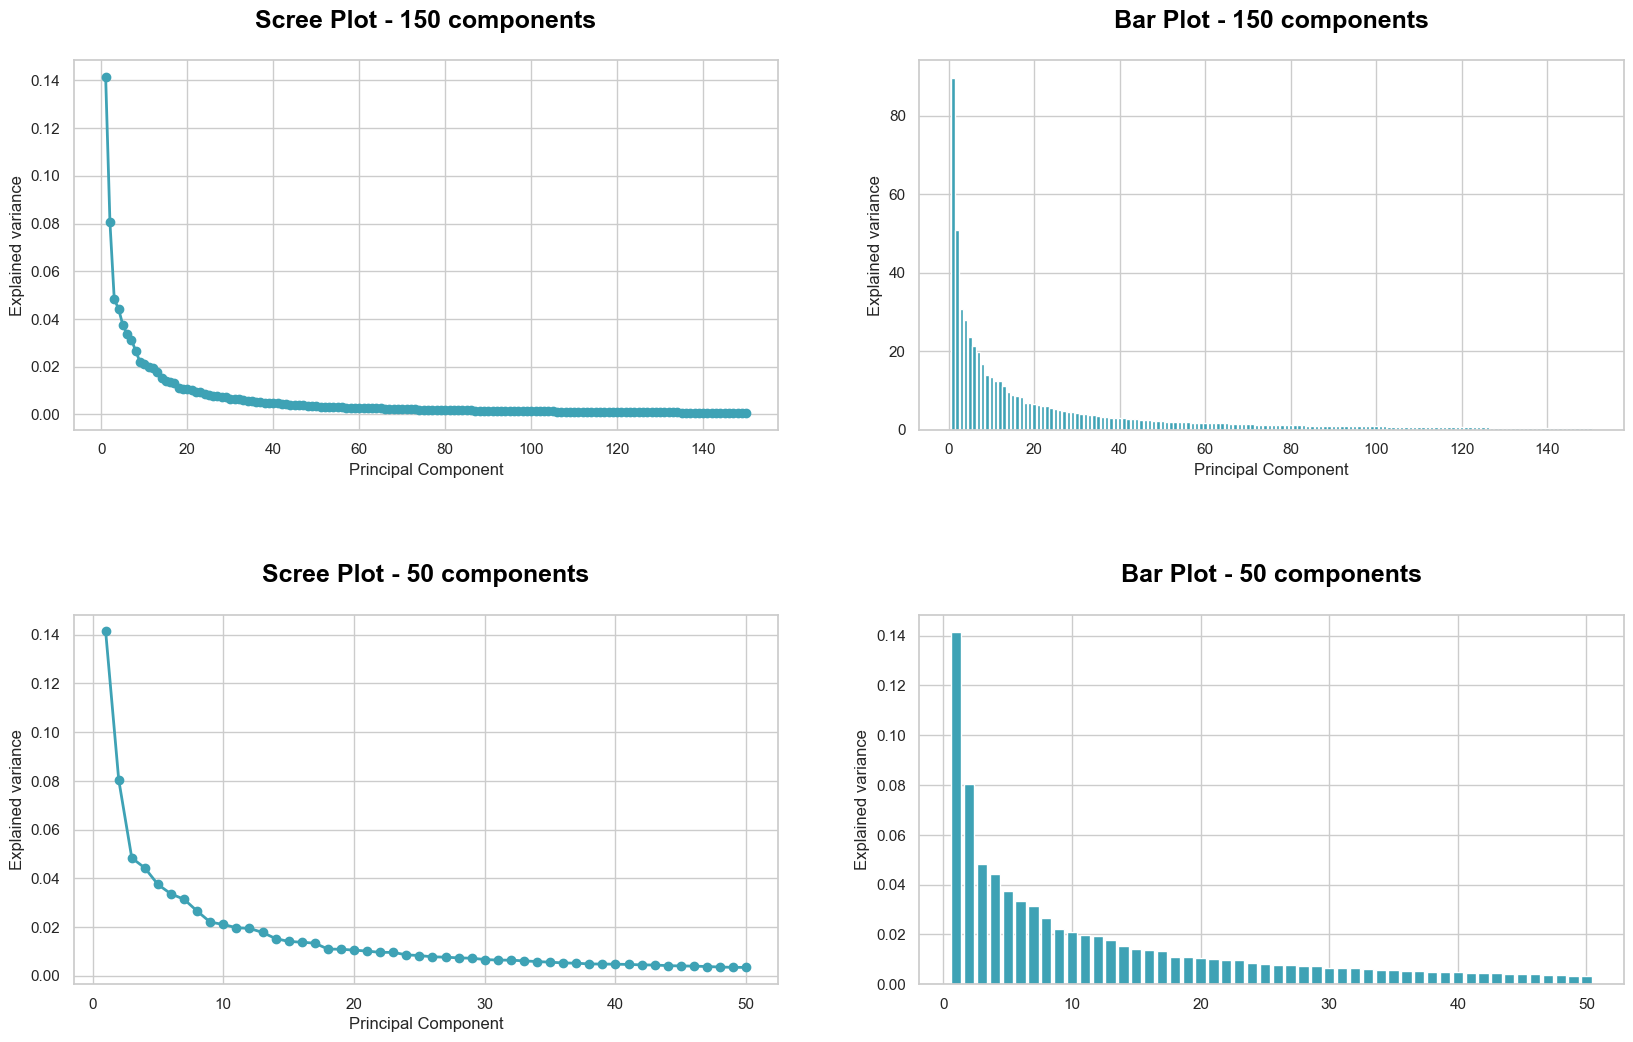

In [86]:
# Create a figure with two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'hspace': 0.5})

# Plot the first subplot
PC_values = np.arange(pca_z.n_components_) + 1
ax1.plot(PC_values, pca_z.explained_variance_ratio_, 'o-', linewidth=2, color='#3ea2b5')
ax1.set_title('Scree Plot - 150 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained variance')
ax1.grid(True)

# Plot the second subplot
ax2.bar(range(1, len(pca_z.explained_variance_) + 1), pca_z.explained_variance_, color='#3ea2b5')
ax2.set_title('Bar Plot - 150 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained variance')
ax2.grid(True)

# Plot the third subplot
PC_values = np.arange(50) + 1
explained_variance_ratio = pca_z.explained_variance_ratio_[:50]
ax3.plot(PC_values, explained_variance_ratio, 'o-', linewidth=2, color='#3ea2b5')
ax3.set_title('Scree Plot - 50 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained variance')
ax3.grid(True)

# Plot the fourth subplot
ax4.bar(range(1, 51), explained_variance_ratio, color='#3ea2b5')
ax4.set_title('Bar Plot - 50 components', fontsize= 18, fontweight= 'heavy', color = 'black', y=1.05, pad=10)
ax2.set_xlabel('Principal Component')
ax4.set_ylabel('Explained variance')
ax4.grid(True)

# Show the combined plot
plt.show()

Thanks to these 2 plots we can see that the elbow is among 0 and 50 components.

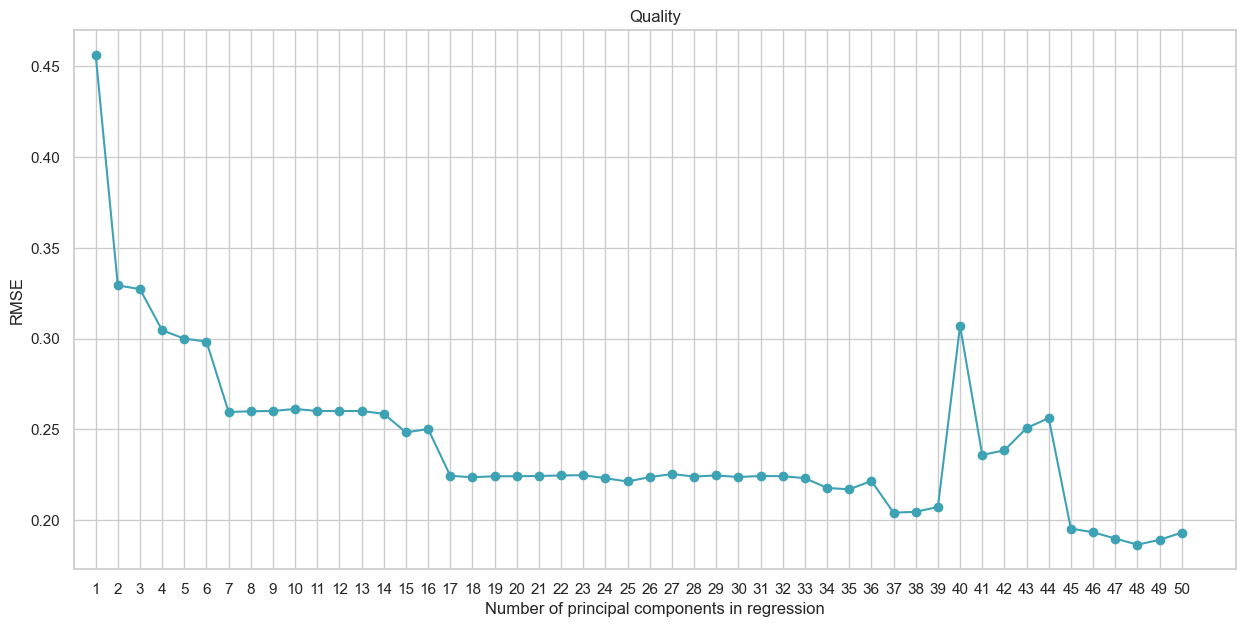

In [87]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize linear regression instance
lin_reg_z = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, 51):
    rmse_score = -1 * cross_val_score(lin_reg_z, 
                                      X_train_pca_z[:,:i], # sUse first k principal components
                                      y_train_z, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.figure(figsize=(15, 7))
plt.plot(rmse_list, '-o', color='#3ea2b5')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1)
plt.xticks(np.arange(50), np.arange(1, 51))
plt.show()

In [88]:
# Computing the cumulative explained variance  
sum = 0
for i in range(17):
    temp = round(pca_z.explained_variance_ratio_[i]*100, 2)
    sum += temp
print('Variance:', round(sum), '%')

Variance: 60 %


#### Hyperparameters tuning

As with the other target, i tried to find a trade off value for the principal number of components. 

Differntly from the redshift case, i decided to use the smallest possible number of components and still have good rmse and explained variance.

In [89]:
# Optimal number of principal components
best_pc_num_z = 17

In [90]:
"""
## --------------------------------LASSO AND RIDGE --------------------------------##
# Define a range of alpha values to search
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0]  # Adjust the range as needed

# Define the parameter grid for Ridge and Lasso
param_grid = [{'alpha': alpha_values, 'max_iter': [10000]}]

# Perform grid search for Ridge
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid_search.fit(X_train_pca_z[:, :best_pc_num_z], y_train_z)

# Perform grid search for Lasso
lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='r2')
lasso_grid_search.fit(X_train_pca_z[:, :best_pc_num_z], y_train_z)

# Get the best parameters for Ridge and Lasso
best_alpha_ridge = ridge_grid_search.best_params_['alpha']
best_alpha_lasso = lasso_grid_search.best_params_['alpha']

print("Best Ridge alpha:", best_alpha_ridge)
print("Best Lasso alpha:", best_alpha_lasso)


## -------------------------------- SVM REGRESSOR --------------------------------##
# Define grid search
param_grid = {'C': [10, 100],  
              'gamma': [0.001, 0.0001]}  

# Grid
grid_search = GridSearchCV(SVR(), param_grid) 

# Fit grid search
grid_result = grid_search.fit(X_train_pca_z[:,:best_pc_num_z], y_train_z)

# Print grid search summary
print("Best Estimators for SVR:", grid_search.best_estimator_)
"""

'\n## --------------------------------LASSO AND RIDGE --------------------------------##\n# Define a range of alpha values to search\nalpha_values = [0.001, 0.01, 0.1, 1.0, 10.0]  # Adjust the range as needed\n\n# Define the parameter grid for Ridge and Lasso\nparam_grid = [{\'alpha\': alpha_values, \'max_iter\': [10000]}]\n\n# Perform grid search for Ridge\nridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring=\'r2\')\nridge_grid_search.fit(X_train_pca_z[:, :best_pc_num_z], y_train_z)\n\n# Perform grid search for Lasso\nlasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring=\'r2\')\nlasso_grid_search.fit(X_train_pca_z[:, :best_pc_num_z], y_train_z)\n\n# Get the best parameters for Ridge and Lasso\nbest_alpha_ridge = ridge_grid_search.best_params_[\'alpha\']\nbest_alpha_lasso = lasso_grid_search.best_params_[\'alpha\']\n\nprint("Best Ridge alpha:", best_alpha_ridge)\nprint("Best Lasso alpha:", best_alpha_lasso)\n\n\n## -------------------------------- SVM REG

#### Fitting and Predicting

In [ ]:
# Linear Regression
lin_reg_pca_z = LinearRegression()
lin_reg_pca_z.fit(X_train_pca_z[:,:best_pc_num_z], y_train_z)

# Ridge and Lasso 
ridge_reg_pca_z = Ridge(alpha=10.0, max_iter=10000)  
lasso_reg_pca_z = Lasso(alpha=0.01, max_iter=10000) 
ridge_reg_pca_z.fit(X_train_pca_z[:,:best_pc_num_z],y_train_z)
lasso_reg_pca_z.fit(X_train_pca_z[:,:best_pc_num_z],y_train_z)

# Elastic Net Regression
enet_reg_z = ElasticNet()
enet_reg_z.fit(X_train_pca_z[:,:best_pc_num_z],y_train_z)

# Random Forest
rand_reg_pca_z = RandomForestRegressor()
rand_reg_pca_z.fit(X_train_pca_z[:,:best_pc_num_z], y_train_z)

# SVM
svm_reg_pca_z = SVR(kernel= 'rbf', C=100, gamma=0.0001)
svm_reg_pca_z.fit(X_train_pca_z[:,:best_pc_num_z], y_train_z)

# Predict on the test set
y_pred_lin_pca_z = lin_reg_pca_z.predict(X_test_pca_z[:,:best_pc_num_z])
y_pred_ridge_pca_z = ridge_reg_pca_z.predict(X_test_pca_z[:,:best_pc_num_z])
y_pred_lasso_pca_z= lasso_reg_pca_z.predict(X_test_pca_z[:,:best_pc_num_z])
y_pred_enet_pca_z= enet_reg_z.predict(X_test_pca_z[:,:best_pc_num_z])
y_pred_rand_pca_z = rand_reg_pca_z.predict(X_test_pca_z[:,:best_pc_num_z])
y_pred_svm_pca_z = svm_reg_pca_z.predict(X_test_pca_z[:,:best_pc_num_z])

#### Evaluation with metrics

In [92]:
# MSE
mse_linear_z = mean_squared_error(y_test_z, y_pred_lin_pca_z)
mse_ridge_z = mean_squared_error(y_test_z, y_pred_ridge_pca_z)
mse_lasso_z = mean_squared_error(y_test_z, y_pred_lasso_pca_z)
mse_enet_z = mean_squared_error(y_test_z, y_pred_enet_pca_z)
mse_rand_z = mean_squared_error(y_test_z, y_pred_rand_pca_z)
mse_svm_z = mean_squared_error(y_test_z, y_pred_svm_pca_z)

# MAE
mae_linear_z = mean_absolute_error(y_test_z,y_pred_lin_pca_z)
mae_ridge_z = mean_absolute_error(y_test_z,y_pred_ridge_pca_z)
mae_lasso_z = mean_absolute_error(y_test_z,y_pred_lasso_pca_z)
mae_enet_z = mean_absolute_error(y_test_z,y_pred_enet_pca_z)
mae_rand_z = mean_absolute_error(y_test_z,y_pred_rand_pca_z)
mae_svm_z = mean_absolute_error(y_test_z,y_pred_svm_pca_z)

# RMSE
rmse_linear_z = np.sqrt(mse_linear)
rmse_ridge_z = np.sqrt(mse_ridge)
rmse_lasso_z = np.sqrt(mse_lasso)
rmse_enet_z = np.sqrt(mse_enet)
rmse_rand_z = np.sqrt(mse_rand)
rmse_svm_z = np.sqrt(mse_svm)

# R squared score
r2_linear_z = r2_score(y_test_z,y_pred_lin_pca_z) * 100
r2_ridge_z = r2_score(y_test_z,y_pred_ridge_pca_z) * 100
r2_lasso_z = r2_score(y_test_z,y_pred_lasso_pca_z) * 100
r2_enet_z = r2_score(y_test_z,y_pred_enet_pca_z) * 100
r2_rand_z = r2_score(y_test_z,y_pred_rand_pca_z) * 100
r2_svm_z= r2_score(y_test_z,y_pred_svm_pca_z) * 100


# Create a DataFrame from the dictionary
evaluations_dict_z = {
    'MSE_z': [mse_linear_z, mse_ridge_z, mse_lasso_z, mse_enet_z, mse_rand_z, mse_svm_z],
    'MAE_z': [mae_linear_z, mae_ridge_z, mae_lasso_z, mae_enet_z, mae_rand_z, mae_svm_z],
    'RMSE_z': [rmse_linear_z, rmse_ridge_z, rmse_lasso_z, rmse_enet_z, rmse_rand_z, rmse_svm_z],
    'R-squared_z': [r2_linear_z, r2_ridge_z, r2_lasso_z, r2_enet_z, r2_rand_z, r2_svm_z]
}


# Create a list of regression model names
models = ['Linear Regression', 'Ridge Regression ', 'Lasso Regression', 'Elastic Net Regression', 'Random Forest Regression', 'SVM Regression']

# Create a DataFrame with model names as the index
evaluations_df_z = pd.DataFrame(evaluations_dict_z, index=models)
evaluations_df_z = evaluations_df_z.round(3)

In [93]:
evaluations_df_z

,MSE_z,MAE_z,RMSE_z,R-squared_z
Linear Regression,0.043,0.141,0.145,95.428
Ridge Regression,0.043,0.141,0.145,95.428
Lasso Regression,0.043,0.141,0.144,95.422
Elastic Net Regression,0.091,0.224,0.265,90.432
Random Forest Regression,0.035,0.125,0.107,96.309
SVM Regression,0.025,0.109,0.102,97.311


The values that came out of the regression model are suggesting the PCR perfomed well on the reduced dataset (17 components).

If you increase the number of components, the metrics improve a little bit.

In [94]:
#Before Hyperparameter Tuning
model_ex = Lasso()
model_ex.fit(X_train_pca_z[:,:best_pc_num_z], y_train_z)
y_pred_ex = model_ex.predict(X_test_pca_z[:,:best_pc_num_z])

print("MSE", mean_squared_error(y_test_z, y_pred_ex).round(3))
print("MAE", mean_absolute_error(y_test_z,y_pred_ex).round(3))
print("RMSE" , np.sqrt(mean_squared_error(y_test_z, y_pred_ex)).round(3))
print("R-squared", round(r2_score(y_test_z,y_pred_ex) * 100, 3))

# After Hyperparameter Tuning 
evaluations_df_z.loc['Lasso Regression',:]

MSE 0.123
MAE 0.266
RMSE 0.351
R-squared 87.026


MSE_z           0.043
MAE_z           0.141
RMSE_z          0.144
R-squared_z    95.422
Name: Lasso Regression, dtype: float64

#### Plots

The plots are confirming the goodness of the metrics.

In [95]:
# Create a scatter plot for Actual vs Predicted with PCR
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_lin_pca_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_lin_pca_z)], y=[min(y_test_z), max(y_pred_lin_pca_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted PCR')

# Show the plot
fig.show()


In [96]:
# Create subplots 
fig = make_subplots(rows=1, cols=2, subplot_titles=('Ridge Regression Model', 'Lasso Regression Model'))

# Scatter plot for Model 1
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_ridge_pca_z, mode='markers', name='Ridge Regression Model',
                         marker=dict(color='#33ADA4')), row=1, col=1)

# Scatter plot for Model 2
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_lasso_pca_z, mode='markers', name='Lasso Regression Model',
                         marker=dict(color='#2b8cbe')), row=1, col=2)

# Perfect Prediction Line for both subplots
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_ridge_pca_z)], y=[min(y_test_z), max(y_pred_ridge_pca_z)],
                         mode='lines', line=dict(color='red', dash='dash'), name='Perfect Prediction Line'),
                         row=1, col=1)

fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_lasso_pca_z)], y=[min(y_test_z), max(y_pred_lasso_pca_z)],
                         mode='lines', line=dict(color='red', dash='dash'), name='Perfect Prediction Line'),
                         row=1, col=2)

# Set axes labels and title
fig.update_xaxes(title_text='Actual Values', row=1, col=1)
fig.update_xaxes(title_text='Actual Values', row=1, col=2)
fig.update_yaxes(title_text='Predicted Values', row=1, col=1)
fig.update_yaxes(title_text='Predicted Values', row=1, col=2)
fig.update_layout(title='Ridge and Lasso Actual vs Predicted', showlegend=False)

# Show the plot
fig.show()

In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_enet_pca_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_enet_pca_z)], y=[min(y_test_z), max(y_pred_enet_pca_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted with SVM and PCA')

# Show the plot
fig.show()

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_rand_pca_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_rand_pca_z)], y=[min(y_test_z), max(y_pred_rand_pca_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted with Random Forest and PCA')

# Show the plot
fig.show()

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_z, y=y_pred_svm_pca_z, mode='markers', name='Actual vs Predicted',
                         marker=dict(color='#33ADA4'), opacity=0.65))
fig.add_trace(go.Scatter(x=[min(y_test_z), max(y_pred_svm_pca_z)], y=[min(y_test_z), max(y_pred_svm_pca_z)],
                         mode='lines', line=dict(color='#ef3b2c', dash='dash'), name='Perfect Prediction Line'))

# Set axes labels and title
fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs Predicted with SVM and PCA')

# Show the plot
fig.show()

### Regression with PCA and statsmodels

In [100]:
# Using y_ols_z and X_ols_z from previous computation

# Standardize the features
scaler = StandardScaler()
X_ols_standardized = scaler.fit_transform(X_ols_z)

# Applying PCA to reduce dimensionality
pca_z = PCA(n_components=20)  # Specify the number of principal components
X_pca_z = pca_z.fit_transform(X_ols_standardized)

# Split the data into training and testing sets for PCA-transformed data
X_train_ols_pca_z, X_test_ols_pca_z, y_train_ols_pca_z, y_test_ols_pca_z = train_test_split(X_pca_z, y_ols_z, test_size=0.2, random_state=42)

# Fit a linear regression model using the PCA-transformed predictors
model_pca = sm.OLS(y_train_ols_pca_z, sm.add_constant(X_train_ols_pca_z)).fit()

# View the model summary for PCA-transformed data
print(model_pca.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     8016.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:58:16   Log-Likelihood:                 850.06
No. Observations:                7783   AIC:                            -1658.
Df Residuals:                    7762   BIC:                            -1512.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7292      0.002   6793.030      0.0

Good results also with statsmodel. We could say that the model is statistically significant.

### Regression and K-Folds Cross-Validation

With this target I will perform only this technique and not the validation set strategy.

In [101]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0, max_iter=10000),
    "Lasso Regression": Lasso(alpha=0.01, max_iter=10000),
    "Elastic Net Regression": ElasticNet(),
    "Random Forest Regression": RandomForestRegressor(),
    "SVM Regression": SVR(kernel= 'rbf', C=100, gamma=0.0001),
}

# Initialize empty dictionaries to store evaluation metrics
evaluation_metrics = {
    'Model': [],
    'MSE': [],
    'MAE': [],
    'RMSE': [],
    'R-squared': [],
}

# Define the list of scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

# Perform cross-validation and calculate metrics for each model
for model_name, model in models.items():
    # Computing the metrics
    cv_results = cross_validate(model, X_train_pca_z[:, :best_pc_num_z], y_train_z, cv=5, scoring=scoring_metrics)

    # Append metrics to the dictionary with the appropriate transformations
    evaluation_metrics['Model'].append(model_name)
    evaluation_metrics['MSE'].append(-cv_results['test_neg_mean_squared_error'].mean())
    evaluation_metrics['MAE'].append(-cv_results['test_neg_mean_absolute_error'].mean())
    evaluation_metrics['RMSE'].append(-cv_results['test_neg_root_mean_squared_error'].mean())
    evaluation_metrics['R-squared'].append(cv_results['test_r2'].mean() * 100)

# Create a DataFrame from the dictionary
cross_validation_results_z = pd.DataFrame(evaluation_metrics)
cross_validation_results_z.set_index('Model', inplace=True)
cross_validation_results_z = cross_validation_results_z.round(3)

In [102]:
# Results of cross validation
cross_validation_results_z

,MSE,MAE,RMSE,R-squared
Model,,,,
Linear Regression,0.050,0.151,0.224,95.058
Ridge Regression,0.050,0.151,0.224,95.059
Lasso Regression,0.050,0.151,0.224,95.077
Elastic Net Regression,0.105,0.230,0.324,89.669
Random Forest Regression,0.037,0.126,0.191,96.397
SVM Regression,0.030,0.095,0.170,97.101


In [103]:
# Previous results 
evaluations_df_z

,MSE_z,MAE_z,RMSE_z,R-squared_z
Linear Regression,0.043,0.141,0.145,95.428
Ridge Regression,0.043,0.141,0.145,95.428
Lasso Regression,0.043,0.141,0.144,95.422
Elastic Net Regression,0.091,0.224,0.265,90.432
Random Forest Regression,0.035,0.125,0.107,96.309
SVM Regression,0.025,0.109,0.102,97.311


#### Summary

We can notice that with this target the results are better, why? The the reasons can be various, and one of them could be the presence of higlhy correlated variables in the datset (for example all the other magnitudes values).

On the other hand, the redshift could be more "difficult" to impute.

### Summary - Regression targets

Summary of what i performed until now, with both targets:
- I tried the simple Regression with the scikit-learn library, keeping all the features. As you can imagine the results are really poor because the number of attributes is too big and the simple regression method too weak for this kinda task. We have a confirmation of that both in the plots and in the evaluated metrics. 
- Then I performed the Regression after the PCA. Thanks to the dimensionality reduction the results are really improved. The best model seems to be the SVM regressor and the Random Forest regressor
- The regressions with the K-folds Cross validation method are done to reduce the problem of overfitting. Indeed the way this algorithm is constructed try to avoid the generalization of the training set. 
- Separating data into training-validation-testing sets is also fundamental for building effective and reliable machine learning models, allowing proper evaluation, preventing overfitting, and ensuring the model's ability to generalize to new data.
- I computed the regression with statsmodels, another library with statistical models, statistical tests, and data exploration tools. Here the regression is done without the PCA and with the PCA. As we have seen with sckit-learn, there is a great improvement with the application of the dimensionality reduction. 

## Class prediction  

#### Classification with different models

Here I will perform several classification models on the attribute class. I show the encoding i have done in the beginning on this attribute (that was categorical), in order to have integer values. In this way we can understand which labels correspond to which numbers.

In [104]:
print('Before the encoding:')
print(df['class'].value_counts(), '\n\nEncoding:')
print(df_encoded['class'].value_counts())

Before the encoding:
GALAXY    8297
STAR       793
QSO        639
Name: class, dtype: int64 

Encoding:
0    8297
2     793
1     639
Name: class, dtype: int64


#### Vectors definitions and PCA

In [105]:
# Defining the target variable we have to predict 
target = 'class'

# Features preparing
X_cls = df_encoded.drop(columns = [target])
y_cls = df_encoded[target]

# Splitting 
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Standardization
X_train_cls = StandardScaler().fit_transform(X_train_cls)
X_test_cls = StandardScaler().fit_transform(X_test_cls)

#### Hyperparameters tuning

First the hyperparameters tuning for the decision tree, random forest and knn. 

In [106]:
'''
# Estimating parameters of DecisionTree Classifiers for best fit
dtr_cl = DecisionTreeClassifier()
parameters={'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
clf = GridSearchCV(dtr_cl, parameters, cv=5,scoring="accuracy")
clf.fit(X_train_cls, y_train_cls)

print("Best parameters: ", clf.best_params_)
'''

'\n# Estimating parameters of DecisionTree Classifiers for best fit\ndtr_cl = DecisionTreeClassifier()\nparameters={\'criterion\':[\'gini\',\'entropy\'],\'max_depth\': np.arange(3, 15)}\nclf = GridSearchCV(dtr_cl, parameters, cv=5,scoring="accuracy")\nclf.fit(X_train_cls, y_train_cls)\n\nprint("Best parameters: ", clf.best_params_)\n'

In [107]:
'''
# Estimating best n_estimator using grid search for Randomforest Classifier
rf_clf=RandomForestClassifier()
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [10],  # Maximum depth of the trees
    'min_samples_split': [2, 5]  # Minimum samples required to split a node
}
clf = GridSearchCV(estimator= rf_clf, param_grid= param_grid, cv=5,scoring="accuracy")
clf.fit(X_train_cls, y_train_cls)

print("Best parameters: ", clf.best_params_)
'''

'\n# Estimating best n_estimator using grid search for Randomforest Classifier\nrf_clf=RandomForestClassifier()\nparam_grid = {\n    \'n_estimators\': [200],  # Number of trees in the forest\n    \'max_depth\': [10],  # Maximum depth of the trees\n    \'min_samples_split\': [2, 5]  # Minimum samples required to split a node\n}\nclf = GridSearchCV(estimator= rf_clf, param_grid= param_grid, cv=5,scoring="accuracy")\nclf.fit(X_train_cls, y_train_cls)\n\nprint("Best parameters: ", clf.best_params_)\n'

In [108]:
# Estimating best n_estimator using grid search for KNN
kf=KFold(n_splits=5,shuffle=True,random_state=42)
parameter={'n_neighbors': np.arange(2, 30, 11)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, param_grid=parameter, cv=kf)
knn_cv.fit(X_train_cls, y_train_cls)
print(knn_cv.best_params_)

{'n_neighbors': 13}


In [109]:
'''
adaboost = AdaBoostClassifier()
param_grid = {
    'n_estimators': [100, 200],  # Number of estimators
    'learning_rate': [0.1, 1.0]  # Learning rate
}
grid_search_adaboost = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_adaboost.fit(X_train_cls, y_train_cls)
print("AdaBoost Best Parameters:", grid_search_adaboost.best_params_)
'''

'\nadaboost = AdaBoostClassifier()\nparam_grid = {\n    \'n_estimators\': [100, 200],  # Number of estimators\n    \'learning_rate\': [0.1, 1.0]  # Learning rate\n}\ngrid_search_adaboost = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring=\'accuracy\')\ngrid_search_adaboost.fit(X_train_cls, y_train_cls)\nprint("AdaBoost Best Parameters:", grid_search_adaboost.best_params_)\n'

#### Fitting and predicting

In [110]:
# Models
logreg_class = LogisticRegression(max_iter= 10000, random_state = 42)
rand_class = RandomForestClassifier(n_estimators = 200, max_depth = 10, min_samples_split = 2)
svm_class = SVC(kernel= 'rbf', C=100, gamma=0.0001)
knn_class = KNeighborsClassifier(n_neighbors = 13)
decision_class = DecisionTreeClassifier(criterion = 'gini', max_depth = 8)
adaboost_class = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 200)
gaussian_class = GaussianNB()

# Fit the model with data
logreg_class.fit(X_train_cls, y_train_cls)
rand_class.fit(X_train_cls, y_train_cls)
svm_class.fit(X_train_cls, y_train_cls)
knn_class.fit(X_train_cls, y_train_cls)
decision_class.fit(X_train_cls, y_train_cls)
adaboost_class.fit(X_train_cls, y_train_cls)
gaussian_class.fit(X_train_cls, y_train_cls)

# Prediction
y_cls_logreg = logreg_class.predict(X_test_cls)
y_cls_rand = rand_class.predict(X_test_cls)
y_cls_svm = svm_class.predict(X_test_cls)
y_cls_knn = knn_class.predict(X_test_cls)
y_cls_decision =decision_class.predict(X_test_cls)
y_cls_adaboost = adaboost_class.predict(X_test_cls)
y_cls_gaussian = gaussian_class.predict(X_test_cls)

#### Evaluation

In [111]:
# Create lists to store metric values
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Decision Tree', 'AdaBoost', 'Gaussian Naïve Bayes']
accuracy_scores = []
recall_scores = []
fbeta_scores = []

# Evaluate each model and store metric values
predictions = [y_cls_logreg, y_cls_rand, y_cls_svm, y_cls_knn, y_cls_decision, y_cls_adaboost, y_cls_gaussian]

for y_pred in predictions:
    acc = round(accuracy_score(y_test_cls, y_pred) * 100, 3)
    recall = round(recall_score(y_test_cls, y_pred, average='micro') * 100, 3)
    fbeta = round(fbeta_score(y_test_cls, y_pred, average='micro', beta=2) * 100, 3)
    
    accuracy_scores.append(acc)
    recall_scores.append(recall)
    fbeta_scores.append(fbeta)

# Create a DataFrame with the metric values for each model
data = {
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'F-beta (beta=2)': fbeta_scores
}

metrics_df = pd.DataFrame(data)

In [112]:
metrics_df

,Model,Accuracy,Recall,F-beta (beta=2)
0,Logistic Regression,99.897,99.897,99.897
1,Random Forest,99.949,99.949,99.949
2,SVM,99.949,99.949,99.949
3,KNN,98.715,98.715,98.715
4,Decision Tree,100.000,100.000,100.000
5,AdaBoost,100.000,100.000,100.000
6,Gaussian Naïve Bayes,99.332,99.332,99.332


Every classifier is giving very high accuracies, and modifications of the parameters lead to even higher values. 
It is possible to see that all the features are enough to classificate the target with a in an accurate way and with few errors. 

#### Confusion matrices

[[1663    2    0]
 [   0  124    0]
 [   0    0  157]]


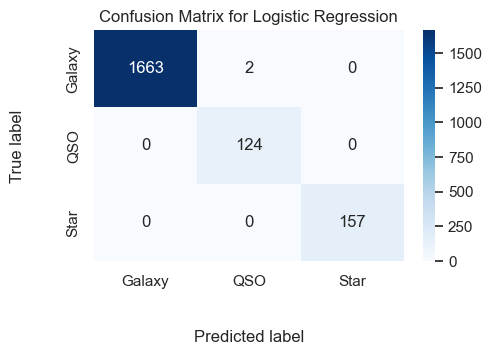

[[1664    1    0]
 [   0  124    0]
 [   0    0  157]]


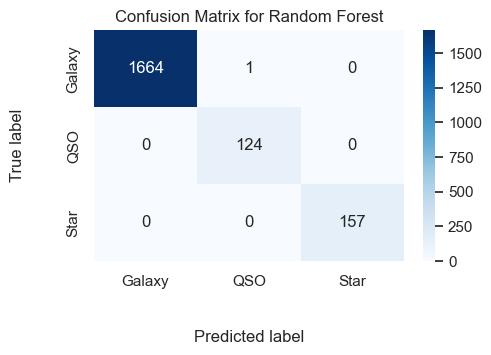

[[1664    1    0]
 [   0  124    0]
 [   0    0  157]]


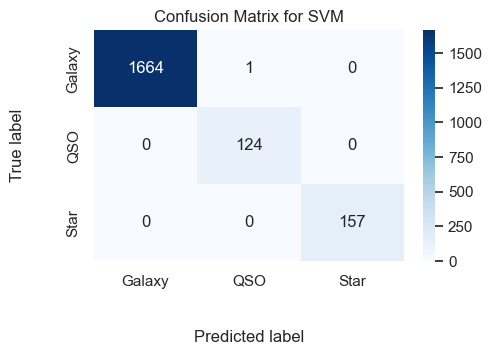

[[1660    5    0]
 [  13  110    1]
 [   3    3  151]]


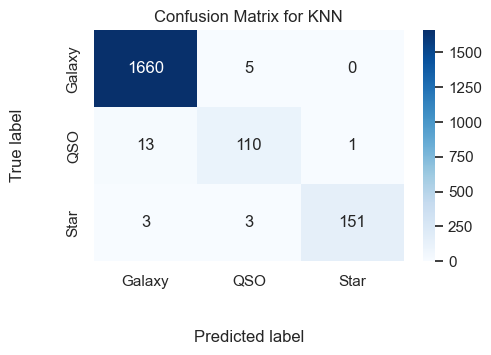

[[1665    0    0]
 [   0  124    0]
 [   0    0  157]]


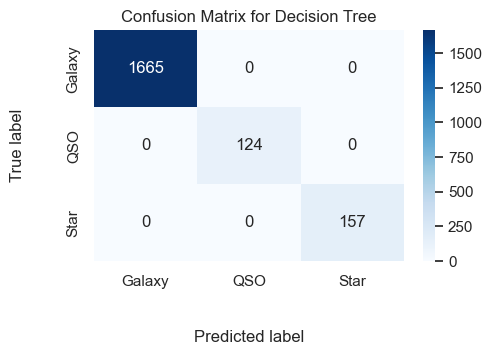

[[1665    0    0]
 [   0  124    0]
 [   0    0  157]]


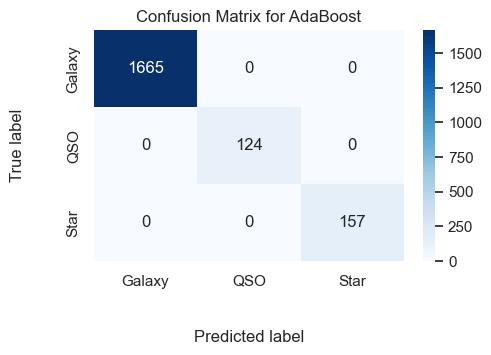

[[1665    0    0]
 [  13  111    0]
 [   0    0  157]]


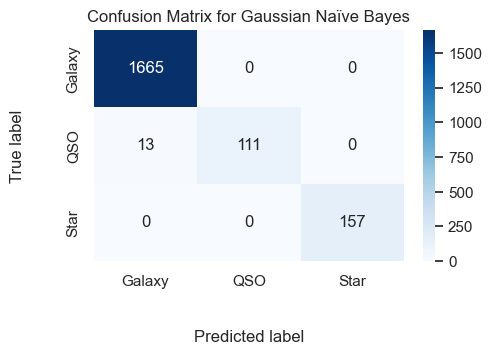

In [113]:
conf_matrices = []

# Calculate and store confusion matrices for each model
for y_pred in predictions:
    conf_matrix = confusion_matrix(y_test_cls, y_pred)
    conf_matrices.append(conf_matrix)

# Plot confusion matrices
for i, conf_matrix in enumerate(conf_matrices):
    plt.figure(figsize=(5, 3))
    model_name = model_names[i]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Galaxy', 'QSO', 'Star'],
                yticklabels=['Galaxy', 'QSO', 'Star'])
    print(conf_matrix)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted label', labelpad= 30)
    plt.ylabel('True label', labelpad= 30)
    plt.show()

#### AUC/ROC curve

I will show an example of the AUC/ROC curve plot.
- The ROC curve is a graphical plot that illustrates the ability of a binary classification system as its discrimination threshold is varied. It's created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings
-  The AUC quantifies the overall performance of a classification model. It's the area under the ROC curve.
- TPR true positive rate, (also called sensitivity) is calculated as TP/TP+FN
- FPR false positive rate is calculated as FP/FP+TN


I perform this analysis only the Random Forest Classifier.

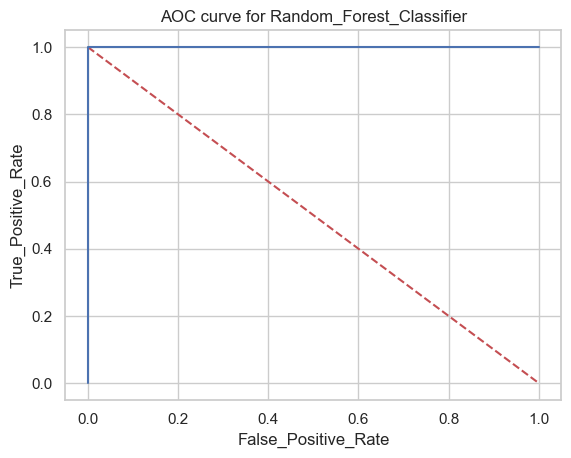

In [114]:
#Finding True positves and false positives in the model 
y_probs_rand = rand_class.predict_proba(X_test_cls)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_cls, y_probs_rand, pos_label=True)

#plotting the graph for area under curve for representing accuracy of data
plt.plot([0,1],[1,0],'r--')
plt.plot(fpr,tpr)
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.title("AOC curve for Random_Forest_Classifier")
plt.show()

We can see that the performance is really good.